##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Overfit and underfit

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/overfit_and_underfit"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/overfit_and_underfit.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/keras/overfit_and_underfit.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/keras/overfit_and_underfit.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

As always, the code in this example will use the `tf.keras` API, which you can learn more about in the TensorFlow [Keras guide](https://www.tensorflow.org/guide/keras).

In both of the previous examples—[classifying text](text_classification_with_hub.ipynb) and [predicting fuel efficiency](regression.ipynb)—the accuracy of models on the validation data would peak after training for a number of epochs and then stagnate or start decreasing.

In other words, your model would *overfit* to the training data. Learning how to deal with overfitting is important. Although it's often possible to achieve high accuracy on the *training set*, what you really want is to develop models that generalize well to a *testing set* (or data they haven't seen before).

The opposite of overfitting is *underfitting*. Underfitting occurs when there is still room for improvement on the train data. This can happen for a number of reasons: If the model is not powerful enough, is over-regularized, or has simply not been trained long enough. This means the network has not learned the relevant patterns in the training data.

If you train for too long though, the model will start to overfit and learn patterns from the training data that don't generalize to the test data. You need to strike a balance. Understanding how to train for an appropriate number of epochs as you'll explore below is a useful skill.

To prevent overfitting, the best solution is to use more complete training data. The dataset should cover the full range of inputs that the model is expected to handle. Additional data may only be useful if it covers new and interesting cases.

A model trained on more complete data will naturally generalize better. When that is no longer possible, the next best solution is to use techniques like regularization. These place constraints on the quantity and type of information your model can store.  If a network can only afford to memorize a small number of patterns, the optimization process will force it to focus on the most prominent patterns, which have a better chance of generalizing well.

In this notebook, you'll explore several common regularization techniques, and use them to improve on a classification model.

## Setup

Before getting started, import the necessary packages:

In [3]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers

print(tf.__version__)

2022-12-14 06:40:09.009844: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-14 06:40:09.009941: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-14 06:40:09.009950: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


2.11.0


In [4]:
!pip install git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

  Cloning https://github.com/tensorflow/docs to /tmpfs/tmp/pip-req-build-ccrps5cs
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmpfs/tmp/pip-req-build-ccrps5cs


  Resolved https://github.com/tensorflow/docs to commit 7ec3498211be67edf739754575ee4745c05b95ef


  Preparing metadata (setup.py) ... -

 done


  Using cached astor-0.8.1-py2.py3-none-any.whl (27 kB)


 \

 done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=180390 sha256=d74aa2786efbee7b4d7c0122797ae408122994e91eab9efbbd2bcb694b3c08ec
  Stored in directory: /tmpfs/tmp/pip-ephem-wheel-cache-zsb44w6i/wheels/fc/f8/3b/5d21409a59cb1be9b1ade11f682039ced75b84de9dd6a0c8de
Successfully built tensorflow-docs


In [5]:
from  IPython import display
from matplotlib import pyplot as plt

import numpy as np

import pathlib
import shutil
import tempfile


In [6]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

## The Higgs dataset

The goal of this tutorial is not to do particle physics, so don't dwell on the details of the dataset. It contains 11,000,000 examples, each with 28 features, and a binary class label.

In [7]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

      8192/2816407858 [..............................] - ETA: 1s

     16384/2816407858 [..............................] - ETA: 2:29:06

     49152/2816407858 [..............................] - ETA: 1:41:52

     90112/2816407858 [..............................] - ETA: 1:28:13

    188416/2816407858 [..............................] - ETA: 57:17  

    278528/2816407858 [..............................] - ETA: 47:11

    516096/2816407858 [..............................] - ETA: 46:04

    835584/2816407858 [..............................] - ETA: 31:15

   1114112/2816407858 [..............................] - ETA: 27:21

   1441792/2816407858 [..............................] - ETA: 22:46

   1712128/2816407858 [..............................] - ETA: 20:35

   1925120/2816407858 [..............................] - ETA: 20:29

   2252800/2816407858 [..............................] - ETA: 18:33

   2523136/2816407858 [..............................] - ETA: 17:30

   2727936/2816407858 [..............................] - ETA: 17:42

   2990080/2816407858 [..............................] - ETA: 16:56

   3325952/2816407858 [..............................] - ETA: 15:56

   3555328/2816407858 [..............................] - ETA: 16:06

   3825664/2816407858 [..............................] - ETA: 15:34

   4161536/2816407858 [..............................] - ETA: 14:52

   4390912/2816407858 [..............................] - ETA: 15:04

   4669440/2816407858 [..............................] - ETA: 14:40

   5013504/2816407858 [..............................] - ETA: 14:08

   5242880/2816407858 [..............................] - ETA: 14:18

   5480448/2816407858 [..............................] - ETA: 14:07

   5808128/2816407858 [..............................] - ETA: 13:43

   6086656/2816407858 [..............................] - ETA: 13:47

   6356992/2816407858 [..............................] - ETA: 13:35

   6684672/2816407858 [..............................] - ETA: 13:16

   6963200/2816407858 [..............................] - ETA: 13:20

   7241728/2816407858 [..............................] - ETA: 13:09

   7577600/2816407858 [..............................] - ETA: 12:53

   7847936/2816407858 [..............................] - ETA: 12:58

   8142848/2816407858 [..............................] - ETA: 12:47

   8404992/2816407858 [..............................] - ETA: 14:11

   8699904/2816407858 [..............................] - ETA: 13:58

   8929280/2816407858 [..............................] - ETA: 14:06

   9330688/2816407858 [..............................] - ETA: 13:44

   9601024/2816407858 [..............................] - ETA: 13:48

   9986048/2816407858 [..............................] - ETA: 13:30

  10289152/2816407858 [..............................] - ETA: 13:32

  10665984/2816407858 [..............................] - ETA: 13:16

  10985472/2816407858 [..............................] - ETA: 13:17

  11345920/2816407858 [..............................] - ETA: 13:04

  11689984/2816407858 [..............................] - ETA: 13:03

  12058624/2816407858 [..............................] - ETA: 12:50

  12394496/2816407858 [..............................] - ETA: 12:50

  12632064/2816407858 [..............................] - ETA: 12:47

  13041664/2816407858 [..............................] - ETA: 12:33

  13344768/2816407858 [..............................] - ETA: 12:36

  13754368/2816407858 [..............................] - ETA: 12:23

  14065664/2816407858 [..............................] - ETA: 12:25

  14450688/2816407858 [..............................] - ETA: 12:15

  14786560/2816407858 [..............................] - ETA: 12:08

  15040512/2816407858 [..............................] - ETA: 12:12

  15482880/2816407858 [..............................] - ETA: 12:00

  15777792/2816407858 [..............................] - ETA: 12:03

  16211968/2816407858 [..............................] - ETA: 11:52

  16515072/2816407858 [..............................] - ETA: 11:55

  16949248/2816407858 [..............................] - ETA: 11:45

  17268736/2816407858 [..............................] - ETA: 11:47

  17678336/2816407858 [..............................] - ETA: 11:38

  18014208/2816407858 [..............................] - ETA: 11:40

  18423808/2816407858 [..............................] - ETA: 11:32

  18776064/2816407858 [..............................] - ETA: 11:32

  19120128/2816407858 [..............................] - ETA: 11:27

  19554304/2816407858 [..............................] - ETA: 11:25

  20021248/2816407858 [..............................] - ETA: 11:16

  20332544/2816407858 [..............................] - ETA: 11:19

  20799488/2816407858 [..............................] - ETA: 11:10

  21110784/2816407858 [..............................] - ETA: 11:12

  21372928/2816407858 [..............................] - ETA: 11:10

  21823488/2816407858 [..............................] - ETA: 11:03

  22142976/2816407858 [..............................] - ETA: 11:04

  22429696/2816407858 [..............................] - ETA: 11:02

  22855680/2816407858 [..............................] - ETA: 10:56

  23216128/2816407858 [..............................] - ETA: 10:56

  23502848/2816407858 [..............................] - ETA: 10:54

  23928832/2816407858 [..............................] - ETA: 10:48

  24289280/2816407858 [..............................] - ETA: 10:49

  24584192/2816407858 [..............................] - ETA: 10:47

  25018368/2816407858 [..............................] - ETA: 10:41

  25378816/2816407858 [..............................] - ETA: 10:42

  25665536/2816407858 [..............................] - ETA: 10:40

  26099712/2816407858 [..............................] - ETA: 10:35

  26476544/2816407858 [..............................] - ETA: 10:31

  26771456/2816407858 [..............................] - ETA: 10:33

  27066368/2816407858 [..............................] - ETA: 10:31

  27533312/2816407858 [..............................] - ETA: 10:26

  27910144/2816407858 [..............................] - ETA: 10:26

  28221440/2816407858 [..............................] - ETA: 10:24

  28696576/2816407858 [..............................] - ETA: 10:19

  29097984/2816407858 [..............................] - ETA: 10:19

  29425664/2816407858 [..............................] - ETA: 10:16

  29876224/2816407858 [..............................] - ETA: 10:12

  30326784/2816407858 [..............................] - ETA: 10:11

  30662656/2816407858 [..............................] - ETA: 10:09

  31105024/2816407858 [..............................] - ETA: 10:04

  31596544/2816407858 [..............................] - ETA: 10:03

  31956992/2816407858 [..............................] - ETA: 10:00

  32423936/2816407858 [..............................] - ETA: 9:56 

  32907264/2816407858 [..............................] - ETA: 9:51

  33251328/2816407858 [..............................] - ETA: 9:53

  33652736/2816407858 [..............................] - ETA: 9:50

  34144256/2816407858 [..............................] - ETA: 9:45

  34611200/2816407858 [..............................] - ETA: 9:44

  35045376/2816407858 [..............................] - ETA: 9:41

  35561472/2816407858 [..............................] - ETA: 9:36

  36036608/2816407858 [..............................] - ETA: 9:33

  36421632/2816407858 [..............................] - ETA: 9:33

  36814848/2816407858 [..............................] - ETA: 9:31

  37462016/2816407858 [..............................] - ETA: 9:25

  37920768/2816407858 [..............................] - ETA: 9:21

  38322176/2816407858 [..............................] - ETA: 9:22

  38731776/2816407858 [..............................] - ETA: 9:19

  39321600/2816407858 [..............................] - ETA: 9:14

  39878656/2816407858 [..............................] - ETA: 9:10

  40312832/2816407858 [..............................] - ETA: 9:07

  40730624/2816407858 [..............................] - ETA: 9:08

  41156608/2816407858 [..............................] - ETA: 9:05

  41762816/2816407858 [..............................] - ETA: 9:22

  42221568/2816407858 [..............................] - ETA: 9:19

  42639360/2816407858 [..............................] - ETA: 9:20

  43237376/2816407858 [..............................] - ETA: 9:15

  43786240/2816407858 [..............................] - ETA: 9:11

  44228608/2816407858 [..............................] - ETA: 9:11

  44875776/2816407858 [..............................] - ETA: 9:06

  45228032/2816407858 [..............................] - ETA: 9:21

  45588480/2816407858 [..............................] - ETA: 9:20

  46104576/2816407858 [..............................] - ETA: 9:16

  46571520/2816407858 [..............................] - ETA: 9:14

  47030272/2816407858 [..............................] - ETA: 9:13

  47652864/2816407858 [..............................] - ETA: 9:09

  48300032/2816407858 [..............................] - ETA: 9:04

  48889856/2816407858 [..............................] - ETA: 9:01

  49446912/2816407858 [..............................] - ETA: 8:57

  49987584/2816407858 [..............................] - ETA: 8:56

  50683904/2816407858 [..............................] - ETA: 8:51

  51372032/2816407858 [..............................] - ETA: 8:47

  52019200/2816407858 [..............................] - ETA: 8:43

  52600832/2816407858 [..............................] - ETA: 8:39

  53166080/2816407858 [..............................] - ETA: 8:36

  53731328/2816407858 [..............................] - ETA: 8:35

  54468608/2816407858 [..............................] - ETA: 8:31

  55238656/2816407858 [..............................] - ETA: 8:26

  55934976/2816407858 [..............................] - ETA: 8:22

  56565760/2816407858 [..............................] - ETA: 8:19

  57204736/2816407858 [..............................] - ETA: 8:15

  57835520/2816407858 [..............................] - ETA: 8:14

  58646528/2816407858 [..............................] - ETA: 8:09

  59408384/2816407858 [..............................] - ETA: 8:05

  60186624/2816407858 [..............................] - ETA: 8:01

  60850176/2816407858 [..............................] - ETA: 7:58

  61546496/2816407858 [..............................] - ETA: 7:55

  62234624/2816407858 [..............................] - ETA: 7:53

  63070208/2816407858 [..............................] - ETA: 7:49

  63905792/2816407858 [..............................] - ETA: 7:45

  64749568/2816407858 [..............................] - ETA: 7:41

  65445888/2816407858 [..............................] - ETA: 7:38

  65855488/2816407858 [..............................] - ETA: 7:51

  66486272/2816407858 [..............................] - ETA: 7:49

  67198976/2816407858 [..............................] - ETA: 7:46

  67862528/2816407858 [..............................] - ETA: 7:43

  68583424/2816407858 [..............................] - ETA: 7:40

  69287936/2816407858 [..............................] - ETA: 7:39

  70205440/2816407858 [..............................] - ETA: 7:35

  70991872/2816407858 [..............................] - ETA: 7:47

  71606272/2816407858 [..............................] - ETA: 7:45

  72400896/2816407858 [..............................] - ETA: 7:42

  73203712/2816407858 [..............................] - ETA: 7:38

  73940992/2816407858 [..............................] - ETA: 7:37

  74874880/2816407858 [..............................] - ETA: 7:33

  75841536/2816407858 [..............................] - ETA: 7:29

  76849152/2816407858 [..............................] - ETA: 7:25

  77807616/2816407858 [..............................] - ETA: 7:21

  77832192/2816407858 [..............................] - ETA: 7:34

  78364672/2816407858 [..............................] - ETA: 7:32

  79159296/2816407858 [..............................] - ETA: 7:29

  80060416/2816407858 [..............................] - ETA: 7:26

  80986112/2816407858 [..............................] - ETA: 7:22

  81895424/2816407858 [..............................] - ETA: 7:19

  82788352/2816407858 [..............................] - ETA: 7:16

  83689472/2816407858 [..............................] - ETA: 7:13

  84721664/2816407858 [..............................] - ETA: 7:10

  85114880/2816407858 [..............................] - ETA: 7:19

  85721088/2816407858 [..............................] - ETA: 7:18

  86163456/2816407858 [..............................] - ETA: 7:30

  86704128/2816407858 [..............................] - ETA: 7:29

  87564288/2816407858 [..............................] - ETA: 7:26

  88539136/2816407858 [..............................] - ETA: 7:23

  89546752/2816407858 [..............................] - ETA: 7:19

  90480640/2816407858 [..............................] - ETA: 7:16

  91430912/2816407858 [..............................] - ETA: 7:13

  92405760/2816407858 [..............................] - ETA: 7:10

  93569024/2816407858 [..............................] - ETA: 7:06

  94732288/2816407858 [>.............................] - ETA: 7:02

  94937088/2816407858 [>.............................] - ETA: 7:13

  95551488/2816407858 [>.............................] - ETA: 7:11

  96509952/2816407858 [>.............................] - ETA: 7:08

  97566720/2816407858 [>.............................] - ETA: 7:05

  98656256/2816407858 [>.............................] - ETA: 7:01

  99778560/2816407858 [>.............................] - ETA: 6:58

 100950016/2816407858 [>.............................] - ETA: 6:54

 102088704/2816407858 [>.............................] - ETA: 6:51

 103211008/2816407858 [>.............................] - ETA: 6:48

 103727104/2816407858 [>.............................] - ETA: 6:56

 104538112/2816407858 [>.............................] - ETA: 6:54

 105578496/2816407858 [>.............................] - ETA: 6:51

 106733568/2816407858 [>.............................] - ETA: 6:48

 107954176/2816407858 [>.............................] - ETA: 6:44

 109166592/2816407858 [>.............................] - ETA: 6:41

 110370816/2816407858 [>.............................] - ETA: 6:37

 111599616/2816407858 [>.............................] - ETA: 6:35

 113016832/2816407858 [>.............................] - ETA: 6:31

 114434048/2816407858 [>.............................] - ETA: 6:27

 114630656/2816407858 [>.............................] - ETA: 6:36

 115417088/2816407858 [>.............................] - ETA: 6:34

 116572160/2816407858 [>.............................] - ETA: 6:31

 117710848/2816407858 [>.............................] - ETA: 6:29

 118169600/2816407858 [>.............................] - ETA: 6:37

 118890496/2816407858 [>.............................] - ETA: 6:35

 120053760/2816407858 [>.............................] - ETA: 6:32

 121274368/2816407858 [>.............................] - ETA: 6:29

 122650624/2816407858 [>.............................] - ETA: 6:26

 124051456/2816407858 [>.............................] - ETA: 6:22

 125476864/2816407858 [>.............................] - ETA: 6:19

 125919232/2816407858 [>.............................] - ETA: 6:28

 126730240/2816407858 [>.............................] - ETA: 6:26

 127942656/2816407858 [>.............................] - ETA: 6:24

 129236992/2816407858 [>.............................] - ETA: 6:21

 130654208/2816407858 [>.............................] - ETA: 6:17

 132087808/2816407858 [>.............................] - ETA: 6:14

 133627904/2816407858 [>.............................] - ETA: 6:11

 134184960/2816407858 [>.............................] - ETA: 6:17

 135143424/2816407858 [>.............................] - ETA: 6:15

 135299072/2816407858 [>.............................] - ETA: 6:24

 135962624/2816407858 [>.............................] - ETA: 6:23

 136151040/2816407858 [>.............................] - ETA: 6:32

 136814592/2816407858 [>.............................] - ETA: 6:31

 138067968/2816407858 [>.............................] - ETA: 6:28

 139403264/2816407858 [>.............................] - ETA: 6:25

 140886016/2816407858 [>.............................] - ETA: 6:22

 142458880/2816407858 [>.............................] - ETA: 6:18

 143097856/2816407858 [>.............................] - ETA: 6:25

 143949824/2816407858 [>.............................] - ETA: 6:23

 145244160/2816407858 [>.............................] - ETA: 6:21

 146661376/2816407858 [>.............................] - ETA: 6:18

 148209664/2816407858 [>.............................] - ETA: 6:14

 149716992/2816407858 [>.............................] - ETA: 6:11

 151396352/2816407858 [>.............................] - ETA: 6:08

 153124864/2816407858 [>.............................] - ETA: 6:04

 154861568/2816407858 [>.............................] - ETA: 6:01

 156647424/2816407858 [>.............................] - ETA: 5:57

 158457856/2816407858 [>.............................] - ETA: 5:54

 160292864/2816407858 [>.............................] - ETA: 5:50

 162152448/2816407858 [>.............................] - ETA: 5:47

 163979264/2816407858 [>.............................] - ETA: 5:44

 165855232/2816407858 [>.............................] - ETA: 5:41

 167870464/2816407858 [>.............................] - ETA: 5:37

 169902080/2816407858 [>.............................] - ETA: 5:33

 171991040/2816407858 [>.............................] - ETA: 5:30

 174063616/2816407858 [>.............................] - ETA: 5:26

 176144384/2816407858 [>.............................] - ETA: 5:23

 178266112/2816407858 [>.............................] - ETA: 5:20

 180428800/2816407858 [>.............................] - ETA: 5:16

 182542336/2816407858 [>.............................] - ETA: 5:13

 184631296/2816407858 [>.............................] - ETA: 5:10

 184852480/2816407858 [>.............................] - ETA: 5:16

 185966592/2816407858 [>.............................] - ETA: 5:15

 187678720/2816407858 [>.............................] - ETA: 5:12

 189440000/2816407858 [=>............................] - ETA: 5:10

 191406080/2816407858 [=>............................] - ETA: 5:07

 193175552/2816407858 [=>............................] - ETA: 5:11

 194281472/2816407858 [=>............................] - ETA: 5:09

 196018176/2816407858 [=>............................] - ETA: 5:07

 197787648/2816407858 [=>............................] - ETA: 5:05

 199712768/2816407858 [=>............................] - ETA: 5:02

 201703424/2816407858 [=>............................] - ETA: 5:00

 203849728/2816407858 [=>............................] - ETA: 4:57

 206127104/2816407858 [=>............................] - ETA: 4:54

 208437248/2816407858 [=>............................] - ETA: 4:51

 210829312/2816407858 [=>............................] - ETA: 4:48

 210894848/2816407858 [=>............................] - ETA: 4:54

 212115456/2816407858 [=>............................] - ETA: 4:53

 213884928/2816407858 [=>............................] - ETA: 4:51

 215982080/2816407858 [=>............................] - ETA: 4:48

 218136576/2816407858 [=>............................] - ETA: 4:46

 220430336/2816407858 [=>............................] - ETA: 4:43

 222896128/2816407858 [=>............................] - ETA: 4:40

 225271808/2816407858 [=>............................] - ETA: 4:38

 227647488/2816407858 [=>............................] - ETA: 4:35

 230170624/2816407858 [=>............................] - ETA: 4:32

 232767488/2816407858 [=>............................] - ETA: 4:30

 235372544/2816407858 [=>............................] - ETA: 4:27

 238026752/2816407858 [=>............................] - ETA: 4:24

 240730112/2816407858 [=>............................] - ETA: 4:22

 241819648/2816407858 [=>............................] - ETA: 4:26

 243212288/2816407858 [=>............................] - ETA: 4:25

 245350400/2816407858 [=>............................] - ETA: 4:23

 247676928/2816407858 [=>............................] - ETA: 4:20

 250101760/2816407858 [=>............................] - ETA: 4:18

 250281984/2816407858 [=>............................] - ETA: 4:23

 251518976/2816407858 [=>............................] - ETA: 4:22

 253591552/2816407858 [=>............................] - ETA: 4:20

 255868928/2816407858 [=>............................] - ETA: 4:18

 258318336/2816407858 [=>............................] - ETA: 4:16

 260653056/2816407858 [=>............................] - ETA: 4:14

 263110656/2816407858 [=>............................] - ETA: 4:12

 265838592/2816407858 [=>............................] - ETA: 4:09

 268713984/2816407858 [=>............................] - ETA: 4:07

 271368192/2816407858 [=>............................] - ETA: 4:09

 272826368/2816407858 [=>............................] - ETA: 4:08

 275021824/2816407858 [=>............................] - ETA: 4:06

 277438464/2816407858 [=>............................] - ETA: 4:04

 280010752/2816407858 [=>............................] - ETA: 4:02

 280150016/2816407858 [=>............................] - ETA: 4:06

 281477120/2816407858 [=>............................] - ETA: 4:06

 283721728/2816407858 [==>...........................] - ETA: 4:04

 286105600/2816407858 [==>...........................] - ETA: 4:02

 288636928/2816407858 [==>...........................] - ETA: 4:00

 288997376/2816407858 [==>...........................] - ETA: 4:01

 291454976/2816407858 [==>...........................] - ETA: 3:59

 294035456/2816407858 [==>...........................] - ETA: 3:58

 296198144/2816407858 [==>...........................] - ETA: 3:56

 297902080/2816407858 [==>...........................] - ETA: 3:55

 299573248/2816407858 [==>...........................] - ETA: 3:54

 302137344/2816407858 [==>...........................] - ETA: 3:52

 304750592/2816407858 [==>...........................] - ETA: 3:50

 307060736/2816407858 [==>...........................] - ETA: 3:49

 309682176/2816407858 [==>...........................] - ETA: 3:47

 312107008/2816407858 [==>...........................] - ETA: 3:45

 314818560/2816407858 [==>...........................] - ETA: 3:44

 317513728/2816407858 [==>...........................] - ETA: 3:42

 320045056/2816407858 [==>...........................] - ETA: 3:40

 322273280/2816407858 [==>...........................] - ETA: 3:39

 323919872/2816407858 [==>...........................] - ETA: 3:38

 325738496/2816407858 [==>...........................] - ETA: 3:41

 327163904/2816407858 [==>...........................] - ETA: 3:40

 329310208/2816407858 [==>...........................] - ETA: 3:39

 331456512/2816407858 [==>...........................] - ETA: 3:37

 333766656/2816407858 [==>...........................] - ETA: 3:36

 336297984/2816407858 [==>...........................] - ETA: 3:35

 338952192/2816407858 [==>...........................] - ETA: 3:33

 339255296/2816407858 [==>...........................] - ETA: 3:36

 340172800/2816407858 [==>...........................] - ETA: 3:40

 340918272/2816407858 [==>...........................] - ETA: 3:39

 342114304/2816407858 [==>...........................] - ETA: 3:39

 344276992/2816407858 [==>...........................] - ETA: 3:38

 346644480/2816407858 [==>...........................] - ETA: 3:36

 347021312/2816407858 [==>...........................] - ETA: 3:39

 348487680/2816407858 [==>...........................] - ETA: 3:39

 350699520/2816407858 [==>...........................] - ETA: 3:37

 353124352/2816407858 [==>...........................] - ETA: 3:36

 355639296/2816407858 [==>...........................] - ETA: 3:35

 356450304/2816407858 [==>...........................] - ETA: 3:38

 357433344/2816407858 [==>...........................] - ETA: 3:40

 358539264/2816407858 [==>...........................] - ETA: 3:40

 360783872/2816407858 [==>...........................] - ETA: 3:39

 363110400/2816407858 [==>...........................] - ETA: 3:37

 365658112/2816407858 [==>...........................] - ETA: 3:36

 368320512/2816407858 [==>...........................] - ETA: 3:35

 371040256/2816407858 [==>...........................] - ETA: 3:33

 373874688/2816407858 [==>...........................] - ETA: 3:35

 375504896/2816407858 [==>...........................] - ETA: 3:34

 377962496/2816407858 [===>..........................] - ETA: 3:33

 380608512/2816407858 [===>..........................] - ETA: 3:31

 383467520/2816407858 [===>..........................] - ETA: 3:30

 384000000/2816407858 [===>..........................] - ETA: 3:33

 385548288/2816407858 [===>..........................] - ETA: 3:32

 387866624/2816407858 [===>..........................] - ETA: 3:31

 390225920/2816407858 [===>..........................] - ETA: 3:30

 390832128/2816407858 [===>..........................] - ETA: 3:32

 392183808/2816407858 [===>..........................] - ETA: 3:32

 394477568/2816407858 [===>..........................] - ETA: 3:30

 396861440/2816407858 [===>..........................] - ETA: 3:29

 397254656/2816407858 [===>..........................] - ETA: 3:32

 398565376/2816407858 [===>..........................] - ETA: 3:31

 400883712/2816407858 [===>..........................] - ETA: 3:30

 402964480/2816407858 [===>..........................] - ETA: 3:32

 404250624/2816407858 [===>..........................] - ETA: 3:32

 406601728/2816407858 [===>..........................] - ETA: 3:30

 409157632/2816407858 [===>..........................] - ETA: 3:29

 411885568/2816407858 [===>..........................] - ETA: 3:28

 414351360/2816407858 [===>..........................] - ETA: 3:30

 415154176/2816407858 [===>..........................] - ETA: 3:30

 416825344/2816407858 [===>..........................] - ETA: 3:29

 419225600/2816407858 [===>..........................] - ETA: 3:28

 421822464/2816407858 [===>..........................] - ETA: 3:27

 424542208/2816407858 [===>..........................] - ETA: 3:25

 427311104/2816407858 [===>..........................] - ETA: 3:24

 430080000/2816407858 [===>..........................] - ETA: 3:23

 431267840/2816407858 [===>..........................] - ETA: 3:25

 432709632/2816407858 [===>..........................] - ETA: 3:24

 435093504/2816407858 [===>..........................] - ETA: 3:23

 437616640/2816407858 [===>..........................] - ETA: 3:22

 440131584/2816407858 [===>..........................] - ETA: 3:21

 442621952/2816407858 [===>..........................] - ETA: 3:20

 444522496/2816407858 [===>..........................] - ETA: 3:19

 446251008/2816407858 [===>..........................] - ETA: 3:19

 448266240/2816407858 [===>..........................] - ETA: 3:19

 450150400/2816407858 [===>..........................] - ETA: 3:21

 451002368/2816407858 [===>..........................] - ETA: 3:20

 452460544/2816407858 [===>..........................] - ETA: 3:20

 454868992/2816407858 [===>..........................] - ETA: 3:19

 457293824/2816407858 [===>..........................] - ETA: 3:18

 458645504/2816407858 [===>..........................] - ETA: 3:20

 459972608/2816407858 [===>..........................] - ETA: 3:19

 462315520/2816407858 [===>..........................] - ETA: 3:18

 464666624/2816407858 [===>..........................] - ETA: 3:17

 466968576/2816407858 [===>..........................] - ETA: 3:16

 469319680/2816407858 [===>..........................] - ETA: 3:16

 469729280/2816407858 [====>.........................] - ETA: 3:18

 471023616/2816407858 [====>.........................] - ETA: 3:17

 473292800/2816407858 [====>.........................] - ETA: 3:16

 475668480/2816407858 [====>.........................] - ETA: 3:16

 478248960/2816407858 [====>.........................] - ETA: 3:15

 481034240/2816407858 [====>.........................] - ETA: 3:13

 483868672/2816407858 [====>.........................] - ETA: 3:12

 486449152/2816407858 [====>.........................] - ETA: 3:11

 488316928/2816407858 [====>.........................] - ETA: 3:11

 489963520/2816407858 [====>.........................] - ETA: 3:10

 491610112/2816407858 [====>.........................] - ETA: 3:12

 492134400/2816407858 [====>.........................] - ETA: 3:14

 492806144/2816407858 [====>.........................] - ETA: 3:14

 494223360/2816407858 [====>.........................] - ETA: 3:13

 496623616/2816407858 [====>.........................] - ETA: 3:12

 497377280/2816407858 [====>.........................] - ETA: 3:14

 498704384/2816407858 [====>.........................] - ETA: 3:14

 501030912/2816407858 [====>.........................] - ETA: 3:13

 503570432/2816407858 [====>.........................] - ETA: 3:12

 504848384/2816407858 [====>.........................] - ETA: 3:14

 506281984/2816407858 [====>.........................] - ETA: 3:13

 508674048/2816407858 [====>.........................] - ETA: 3:12

 511238144/2816407858 [====>.........................] - ETA: 3:11

 511475712/2816407858 [====>.........................] - ETA: 3:13

 512884736/2816407858 [====>.........................] - ETA: 3:13

 515227648/2816407858 [====>.........................] - ETA: 3:12

 517570560/2816407858 [====>.........................] - ETA: 3:13

 518938624/2816407858 [====>.........................] - ETA: 3:13

 521232384/2816407858 [====>.........................] - ETA: 3:12

 523624448/2816407858 [====>.........................] - ETA: 3:11

 526204928/2816407858 [====>.........................] - ETA: 3:10

 528924672/2816407858 [====>.........................] - ETA: 3:09

 531357696/2816407858 [====>.........................] - ETA: 3:08

 532938752/2816407858 [====>.........................] - ETA: 3:10

 533733376/2816407858 [====>.........................] - ETA: 3:10

 535404544/2816407858 [====>.........................] - ETA: 3:09

 537804800/2816407858 [====>.........................] - ETA: 3:09

 540401664/2816407858 [====>.........................] - ETA: 3:08

 542416896/2816407858 [====>.........................] - ETA: 3:09

 543776768/2816407858 [====>.........................] - ETA: 3:09

 546127872/2816407858 [====>.........................] - ETA: 3:08

 548503552/2816407858 [====>.........................] - ETA: 3:07

 550109184/2816407858 [====>.........................] - ETA: 3:07

 551714816/2816407858 [====>.........................] - ETA: 3:08

 552943616/2816407858 [====>.........................] - ETA: 3:08

 555302912/2816407858 [====>.........................] - ETA: 3:07

 557522944/2816407858 [====>.........................] - ETA: 3:06

 559456256/2816407858 [====>.........................] - ETA: 3:06

 560431104/2816407858 [====>.........................] - ETA: 3:07

 561635328/2816407858 [====>.........................] - ETA: 3:07

 563986432/2816407858 [=====>........................] - ETA: 3:06

 566493184/2816407858 [=====>........................] - ETA: 3:05

 569171968/2816407858 [=====>........................] - ETA: 3:04

 571834368/2816407858 [=====>........................] - ETA: 3:03

 573931520/2816407858 [=====>........................] - ETA: 3:03

 576364544/2816407858 [=====>........................] - ETA: 3:02

 578969600/2816407858 [=====>........................] - ETA: 3:01

 580067328/2816407858 [=====>........................] - ETA: 3:03

 580812800/2816407858 [=====>........................] - ETA: 3:03

 582377472/2816407858 [=====>........................] - ETA: 3:02

 584810496/2816407858 [=====>........................] - ETA: 3:02

 586956800/2816407858 [=====>........................] - ETA: 3:03

 588439552/2816407858 [=====>........................] - ETA: 3:02

 590864384/2816407858 [=====>........................] - ETA: 3:01

 593387520/2816407858 [=====>........................] - ETA: 3:01

 595894272/2816407858 [=====>........................] - ETA: 3:00

 597262336/2816407858 [=====>........................] - ETA: 3:01

 597966848/2816407858 [=====>........................] - ETA: 3:01

 599293952/2816407858 [=====>........................] - ETA: 3:01

 601686016/2816407858 [=====>........................] - ETA: 3:00

 603602944/2816407858 [=====>........................] - ETA: 3:01

 605052928/2816407858 [=====>........................] - ETA: 3:01

 607485952/2816407858 [=====>........................] - ETA: 3:00

 609959936/2816407858 [=====>........................] - ETA: 3:01

 610713600/2816407858 [=====>........................] - ETA: 3:01

 612335616/2816407858 [=====>........................] - ETA: 3:01

 614727680/2816407858 [=====>........................] - ETA: 3:00

 617349120/2816407858 [=====>........................] - ETA: 2:59

 620109824/2816407858 [=====>........................] - ETA: 2:58

 622952448/2816407858 [=====>........................] - ETA: 2:57

 624721920/2816407858 [=====>........................] - ETA: 2:57

 626409472/2816407858 [=====>........................] - ETA: 2:57

 626761728/2816407858 [=====>........................] - ETA: 2:58

 628211712/2816407858 [=====>........................] - ETA: 2:58

 630538240/2816407858 [=====>........................] - ETA: 2:57

 632963072/2816407858 [=====>........................] - ETA: 2:56

 635551744/2816407858 [=====>........................] - ETA: 2:56

 638328832/2816407858 [=====>........................] - ETA: 2:55

 641155072/2816407858 [=====>........................] - ETA: 2:54

 643997696/2816407858 [=====>........................] - ETA: 2:53

 646627328/2816407858 [=====>........................] - ETA: 2:52

 649093120/2816407858 [=====>........................] - ETA: 2:52

 651649024/2816407858 [=====>........................] - ETA: 2:51

 654368768/2816407858 [=====>........................] - ETA: 2:50

 656744448/2816407858 [=====>........................] - ETA: 2:50

 659611648/2816407858 [======>.......................] - ETA: 2:49

 662405120/2816407858 [======>.......................] - ETA: 2:48

 665214976/2816407858 [======>.......................] - ETA: 2:47

 667549696/2816407858 [======>.......................] - ETA: 2:47

 669999104/2816407858 [======>.......................] - ETA: 2:46

 672178176/2816407858 [======>.......................] - ETA: 2:45

 674873344/2816407858 [======>.......................] - ETA: 2:45

 677675008/2816407858 [======>.......................] - ETA: 2:44

 680296448/2816407858 [======>.......................] - ETA: 2:45

 681107456/2816407858 [======>.......................] - ETA: 2:45

 682778624/2816407858 [======>.......................] - ETA: 2:45

 683704320/2816407858 [======>.......................] - ETA: 2:46

 684498944/2816407858 [======>.......................] - ETA: 2:46

 685875200/2816407858 [======>.......................] - ETA: 2:45

 688308224/2816407858 [======>.......................] - ETA: 2:45

 690765824/2816407858 [======>.......................] - ETA: 2:44

 692060160/2816407858 [======>.......................] - ETA: 2:45

 692764672/2816407858 [======>.......................] - ETA: 2:45

 694272000/2816407858 [======>.......................] - ETA: 2:45

 696713216/2816407858 [======>.......................] - ETA: 2:44

 699219968/2816407858 [======>.......................] - ETA: 2:44

 700325888/2816407858 [======>.......................] - ETA: 2:45

 701603840/2816407858 [======>.......................] - ETA: 2:45

 703946752/2816407858 [======>.......................] - ETA: 2:44

 706420736/2816407858 [======>.......................] - ETA: 2:45

 707796992/2816407858 [======>.......................] - ETA: 2:45

 710164480/2816407858 [======>.......................] - ETA: 2:44

 712794112/2816407858 [======>.......................] - ETA: 2:43

 715554816/2816407858 [======>.......................] - ETA: 2:43

 716800000/2816407858 [======>.......................] - ETA: 2:44

 717684736/2816407858 [======>.......................] - ETA: 2:44

 719257600/2816407858 [======>.......................] - ETA: 2:43

 721707008/2816407858 [======>.......................] - ETA: 2:43

 723484672/2816407858 [======>.......................] - ETA: 2:43

 726016000/2816407858 [======>.......................] - ETA: 2:42

 728342528/2816407858 [======>.......................] - ETA: 2:42

 730472448/2816407858 [======>.......................] - ETA: 2:41

 731889664/2816407858 [======>.......................] - ETA: 2:41

 733372416/2816407858 [======>.......................] - ETA: 2:42

 734134272/2816407858 [======>.......................] - ETA: 2:42

 735723520/2816407858 [======>.......................] - ETA: 2:42

 736845824/2816407858 [======>.......................] - ETA: 2:43

 738058240/2816407858 [======>.......................] - ETA: 2:42

 739729408/2816407858 [======>.......................] - ETA: 2:43

 740401152/2816407858 [======>.......................] - ETA: 2:43

 741801984/2816407858 [======>.......................] - ETA: 2:43

 744218624/2816407858 [======>.......................] - ETA: 2:42

 746749952/2816407858 [======>.......................] - ETA: 2:42

 749264896/2816407858 [======>.......................] - ETA: 2:41

 751747072/2816407858 [=======>......................] - ETA: 2:41

 753147904/2816407858 [=======>......................] - ETA: 2:42

 754524160/2816407858 [=======>......................] - ETA: 2:41

 756850688/2816407858 [=======>......................] - ETA: 2:41

 758579200/2816407858 [=======>......................] - ETA: 2:42

 759930880/2816407858 [=======>......................] - ETA: 2:41

 762281984/2816407858 [=======>......................] - ETA: 2:41

 764690432/2816407858 [=======>......................] - ETA: 2:40

 767270912/2816407858 [=======>......................] - ETA: 2:40

 769998848/2816407858 [=======>......................] - ETA: 2:39

 772317184/2816407858 [=======>......................] - ETA: 2:39

 774103040/2816407858 [=======>......................] - ETA: 2:38

 775995392/2816407858 [=======>......................] - ETA: 2:38

 778395648/2816407858 [=======>......................] - ETA: 2:37

 780820480/2816407858 [=======>......................] - ETA: 2:37

 783278080/2816407858 [=======>......................] - ETA: 2:36

 785924096/2816407858 [=======>......................] - ETA: 2:36

 787931136/2816407858 [=======>......................] - ETA: 2:35

 790347776/2816407858 [=======>......................] - ETA: 2:35

 793001984/2816407858 [=======>......................] - ETA: 2:34

 795697152/2816407858 [=======>......................] - ETA: 2:33

 797745152/2816407858 [=======>......................] - ETA: 2:33

 800243712/2816407858 [=======>......................] - ETA: 2:34

 801013760/2816407858 [=======>......................] - ETA: 2:34

 802611200/2816407858 [=======>......................] - ETA: 2:33

 805036032/2816407858 [=======>......................] - ETA: 2:33

 807567360/2816407858 [=======>......................] - ETA: 2:32

 808747008/2816407858 [=======>......................] - ETA: 2:33

 810016768/2816407858 [=======>......................] - ETA: 2:33

 812351488/2816407858 [=======>......................] - ETA: 2:33

 813531136/2816407858 [=======>......................] - ETA: 2:33

 814923776/2816407858 [=======>......................] - ETA: 2:33

 817233920/2816407858 [=======>......................] - ETA: 2:33

 819036160/2816407858 [=======>......................] - ETA: 2:32

 820371456/2816407858 [=======>......................] - ETA: 2:32

 821919744/2816407858 [=======>......................] - ETA: 2:32

 824049664/2816407858 [=======>......................] - ETA: 2:31

 826384384/2816407858 [=======>......................] - ETA: 2:31

 827744256/2816407858 [=======>......................] - ETA: 2:32

 829022208/2816407858 [=======>......................] - ETA: 2:32

 831406080/2816407858 [=======>......................] - ETA: 2:31

 833765376/2816407858 [=======>......................] - ETA: 2:31

 836255744/2816407858 [=======>......................] - ETA: 2:30

 838721536/2816407858 [=======>......................] - ETA: 2:30

 841351168/2816407858 [=======>......................] - ETA: 2:29

 843972608/2816407858 [=======>......................] - ETA: 2:28

 845684736/2816407858 [========>.....................] - ETA: 2:28

 847241216/2816407858 [========>.....................] - ETA: 2:28

 849879040/2816407858 [========>.....................] - ETA: 2:27

 852656128/2816407858 [========>.....................] - ETA: 2:27

 855392256/2816407858 [========>.....................] - ETA: 2:26

 858030080/2816407858 [========>.....................] - ETA: 2:26

 860667904/2816407858 [========>.....................] - ETA: 2:25

 863436800/2816407858 [========>.....................] - ETA: 2:25

 865525760/2816407858 [========>.....................] - ETA: 2:24

 867540992/2816407858 [========>.....................] - ETA: 2:25

 868999168/2816407858 [========>.....................] - ETA: 2:25

 869572608/2816407858 [========>.....................] - ETA: 2:26

 870809600/2816407858 [========>.....................] - ETA: 2:25

 873201664/2816407858 [========>.....................] - ETA: 2:25

 874668032/2816407858 [========>.....................] - ETA: 2:26

 876044288/2816407858 [========>.....................] - ETA: 2:25

 878313472/2816407858 [========>.....................] - ETA: 2:25

 880607232/2816407858 [========>.....................] - ETA: 2:25

 882950144/2816407858 [========>.....................] - ETA: 2:24

 885489664/2816407858 [========>.....................] - ETA: 2:24

 888143872/2816407858 [========>.....................] - ETA: 2:23

 889839616/2816407858 [========>.....................] - ETA: 2:24

 891494400/2816407858 [========>.....................] - ETA: 2:24

 893829120/2816407858 [========>.....................] - ETA: 2:23

 896139264/2816407858 [========>.....................] - ETA: 2:23

 898580480/2816407858 [========>.....................] - ETA: 2:22

 900997120/2816407858 [========>.....................] - ETA: 2:22

 902529024/2816407858 [========>.....................] - ETA: 2:22

 903913472/2816407858 [========>.....................] - ETA: 2:22

 906289152/2816407858 [========>.....................] - ETA: 2:22

 908853248/2816407858 [========>.....................] - ETA: 2:21

 911532032/2816407858 [========>.....................] - ETA: 2:21

 914333696/2816407858 [========>.....................] - ETA: 2:20

 917315584/2816407858 [========>.....................] - ETA: 2:20

 919052288/2816407858 [========>.....................] - ETA: 2:20

 920559616/2816407858 [========>.....................] - ETA: 2:20

 922861568/2816407858 [========>.....................] - ETA: 2:20

 925425664/2816407858 [========>.....................] - ETA: 2:19

 928178176/2816407858 [========>.....................] - ETA: 2:19

 928751616/2816407858 [========>.....................] - ETA: 2:20

 930119680/2816407858 [========>.....................] - ETA: 2:19

 930127872/2816407858 [========>.....................] - ETA: 2:20

 931356672/2816407858 [========>.....................] - ETA: 2:20

 933404672/2816407858 [========>.....................] - ETA: 2:21

 934731776/2816407858 [========>.....................] - ETA: 2:21

 937091072/2816407858 [========>.....................] - ETA: 2:20

 939384832/2816407858 [=========>....................] - ETA: 2:20

 940965888/2816407858 [=========>....................] - ETA: 2:19

 943235072/2816407858 [=========>....................] - ETA: 2:19

 945356800/2816407858 [=========>....................] - ETA: 2:19

 947142656/2816407858 [=========>....................] - ETA: 2:19

 948527104/2816407858 [=========>....................] - ETA: 2:19

 950943744/2816407858 [=========>....................] - ETA: 2:19

 953458688/2816407858 [=========>....................] - ETA: 2:18

 956022784/2816407858 [=========>....................] - ETA: 2:18

 958808064/2816407858 [=========>....................] - ETA: 2:17

 961634304/2816407858 [=========>....................] - ETA: 2:17

 962748416/2816407858 [=========>....................] - ETA: 2:17

 963534848/2816407858 [=========>....................] - ETA: 2:17

 965197824/2816407858 [=========>....................] - ETA: 2:17

 966877184/2816407858 [=========>....................] - ETA: 2:18

 968253440/2816407858 [=========>....................] - ETA: 2:17

 970596352/2816407858 [=========>....................] - ETA: 2:17

 973004800/2816407858 [=========>....................] - ETA: 2:17

 975585280/2816407858 [=========>....................] - ETA: 2:16

 978296832/2816407858 [=========>....................] - ETA: 2:16

 980918272/2816407858 [=========>....................] - ETA: 2:15

 983023616/2816407858 [=========>....................] - ETA: 2:16

 983793664/2816407858 [=========>....................] - ETA: 2:16

 985391104/2816407858 [=========>....................] - ETA: 2:16

 987791360/2816407858 [=========>....................] - ETA: 2:15

 990314496/2816407858 [=========>....................] - ETA: 2:15

 993075200/2816407858 [=========>....................] - ETA: 2:14

 996048896/2816407858 [=========>....................] - ETA: 2:14

 997810176/2816407858 [=========>....................] - ETA: 2:14

 999301120/2816407858 [=========>....................] - ETA: 2:14

1000767488/2816407858 [=========>....................] - ETA: 2:15

1002045440/2816407858 [=========>....................] - ETA: 2:14

1004453888/2816407858 [=========>....................] - ETA: 2:14

1007034368/2816407858 [=========>....................] - ETA: 2:14

1009770496/2816407858 [=========>....................] - ETA: 2:13

1012244480/2816407858 [=========>....................] - ETA: 2:13

1015037952/2816407858 [=========>....................] - ETA: 2:12

1017724928/2816407858 [=========>....................] - ETA: 2:13

1018511360/2816407858 [=========>....................] - ETA: 2:13

1018904576/2816407858 [=========>....................] - ETA: 2:13

1020035072/2816407858 [=========>....................] - ETA: 2:13

1022189568/2816407858 [=========>....................] - ETA: 2:13

1023451136/2816407858 [=========>....................] - ETA: 2:13

1024770048/2816407858 [=========>....................] - ETA: 2:13

1027104768/2816407858 [=========>....................] - ETA: 2:13

1029513216/2816407858 [=========>....................] - ETA: 2:12

1030856704/2816407858 [=========>....................] - ETA: 2:13

1032265728/2816407858 [=========>....................] - ETA: 2:13

1034625024/2816407858 [==========>...................] - ETA: 2:12

1037131776/2816407858 [==========>...................] - ETA: 2:12

1039745024/2816407858 [==========>...................] - ETA: 2:12

1042546688/2816407858 [==========>...................] - ETA: 2:11

1045585920/2816407858 [==========>...................] - ETA: 2:11

1048346624/2816407858 [==========>...................] - ETA: 2:10

1050607616/2816407858 [==========>...................] - ETA: 2:10

1053212672/2816407858 [==========>...................] - ETA: 2:09

1053827072/2816407858 [==========>...................] - ETA: 2:10

1054810112/2816407858 [==========>...................] - ETA: 2:11

1055399936/2816407858 [==========>...................] - ETA: 2:11

1056636928/2816407858 [==========>...................] - ETA: 2:11

1058996224/2816407858 [==========>...................] - ETA: 2:10

1061543936/2816407858 [==========>...................] - ETA: 2:10

1064263680/2816407858 [==========>...................] - ETA: 2:09

1066614784/2816407858 [==========>...................] - ETA: 2:09

1068744704/2816407858 [==========>...................] - ETA: 2:09

1071497216/2816407858 [==========>...................] - ETA: 2:08

1074192384/2816407858 [==========>...................] - ETA: 2:08

1076912128/2816407858 [==========>...................] - ETA: 2:07

1078083584/2816407858 [==========>...................] - ETA: 2:08

1079574528/2816407858 [==========>...................] - ETA: 2:08

1081876480/2816407858 [==========>...................] - ETA: 2:07

1084162048/2816407858 [==========>...................] - ETA: 2:07

1086504960/2816407858 [==========>...................] - ETA: 2:07

1088299008/2816407858 [==========>...................] - ETA: 2:07

1089413120/2816407858 [==========>...................] - ETA: 2:08

1090682880/2816407858 [==========>...................] - ETA: 2:08

1093025792/2816407858 [==========>...................] - ETA: 2:07

1095532544/2816407858 [==========>...................] - ETA: 2:07

1098137600/2816407858 [==========>...................] - ETA: 2:06

1098899456/2816407858 [==========>...................] - ETA: 2:06

1101004800/2816407858 [==========>...................] - ETA: 2:06

1102929920/2816407858 [==========>...................] - ETA: 2:06

1105362944/2816407858 [==========>...................] - ETA: 2:05

1107902464/2816407858 [==========>...................] - ETA: 2:05

1110597632/2816407858 [==========>...................] - ETA: 2:05

1113169920/2816407858 [==========>...................] - ETA: 2:04

1115496448/2816407858 [==========>...................] - ETA: 2:04

1117560832/2816407858 [==========>...................] - ETA: 2:04

1118281728/2816407858 [==========>...................] - ETA: 2:05

1118773248/2816407858 [==========>...................] - ETA: 2:05

1119830016/2816407858 [==========>...................] - ETA: 2:05

1121763328/2816407858 [==========>...................] - ETA: 2:05

1124212736/2816407858 [==========>...................] - ETA: 2:04

1126825984/2816407858 [===========>..................] - ETA: 2:04

1129562112/2816407858 [===========>..................] - ETA: 2:03

1132380160/2816407858 [===========>..................] - ETA: 2:03

1135026176/2816407858 [===========>..................] - ETA: 2:03

1137426432/2816407858 [===========>..................] - ETA: 2:02

1139974144/2816407858 [===========>..................] - ETA: 2:02

1140957184/2816407858 [===========>..................] - ETA: 2:02

1142636544/2816407858 [===========>..................] - ETA: 2:02

1145069568/2816407858 [===========>..................] - ETA: 2:02

1147478016/2816407858 [===========>..................] - ETA: 2:01

1150009344/2816407858 [===========>..................] - ETA: 2:01

1152761856/2816407858 [===========>..................] - ETA: 2:01

1155710976/2816407858 [===========>..................] - ETA: 2:00

1157382144/2816407858 [===========>..................] - ETA: 2:01

1158889472/2816407858 [===========>..................] - ETA: 2:01

1160216576/2816407858 [===========>..................] - ETA: 2:01

1162592256/2816407858 [===========>..................] - ETA: 2:01

1164435456/2816407858 [===========>..................] - ETA: 2:00

1166524416/2816407858 [===========>..................] - ETA: 2:01

1166589952/2816407858 [===========>..................] - ETA: 2:01

1167048704/2816407858 [===========>..................] - ETA: 2:01

1167638528/2816407858 [===========>..................] - ETA: 2:02

1168367616/2816407858 [===========>..................] - ETA: 2:02

1169735680/2816407858 [===========>..................] - ETA: 2:02

1172348928/2816407858 [===========>..................] - ETA: 2:01

1174994944/2816407858 [===========>..................] - ETA: 2:01

1177714688/2816407858 [===========>..................] - ETA: 2:01

1180499968/2816407858 [===========>..................] - ETA: 2:00

1183432704/2816407858 [===========>..................] - ETA: 2:00

1185685504/2816407858 [===========>..................] - ETA: 1:59

1187905536/2816407858 [===========>..................] - ETA: 1:59

1189658624/2816407858 [===========>..................] - ETA: 1:59

1191837696/2816407858 [===========>..................] - ETA: 1:59

1193754624/2816407858 [===========>..................] - ETA: 1:58

1196105728/2816407858 [===========>..................] - ETA: 1:59

1197621248/2816407858 [===========>..................] - ETA: 1:58

1200152576/2816407858 [===========>..................] - ETA: 1:58

1202642944/2816407858 [===========>..................] - ETA: 1:58

1204920320/2816407858 [===========>..................] - ETA: 1:57

1207304192/2816407858 [===========>..................] - ETA: 1:57

1209712640/2816407858 [===========>..................] - ETA: 1:57

1212301312/2816407858 [===========>..................] - ETA: 1:56

1214144512/2816407858 [===========>..................] - ETA: 1:56

1216380928/2816407858 [===========>..................] - ETA: 1:56

1216798720/2816407858 [===========>..................] - ETA: 1:56

1218134016/2816407858 [===========>..................] - ETA: 1:56

1220583424/2816407858 [============>.................] - ETA: 1:56

1223172096/2816407858 [============>.................] - ETA: 1:55

1225965568/2816407858 [============>.................] - ETA: 1:55

1228742656/2816407858 [============>.................] - ETA: 1:55

1230503936/2816407858 [============>.................] - ETA: 1:54

1233190912/2816407858 [============>.................] - ETA: 1:54

1235714048/2816407858 [============>.................] - ETA: 1:54

1238122496/2816407858 [============>.................] - ETA: 1:54

1238917120/2816407858 [============>.................] - ETA: 1:54

1240596480/2816407858 [============>.................] - ETA: 1:54

1243185152/2816407858 [============>.................] - ETA: 1:53

1245863936/2816407858 [============>.................] - ETA: 1:53

1248165888/2816407858 [============>.................] - ETA: 1:53

1249558528/2816407858 [============>.................] - ETA: 1:53

1251975168/2816407858 [============>.................] - ETA: 1:53

1254408192/2816407858 [============>.................] - ETA: 1:52

1257054208/2816407858 [============>.................] - ETA: 1:52

1259692032/2816407858 [============>.................] - ETA: 1:52

1260822528/2816407858 [============>.................] - ETA: 1:52

1262297088/2816407858 [============>.................] - ETA: 1:52

1264902144/2816407858 [============>.................] - ETA: 1:52

1267621888/2816407858 [============>.................] - ETA: 1:51

1270415360/2816407858 [============>.................] - ETA: 1:51

1273176064/2816407858 [============>.................] - ETA: 1:50

1275011072/2816407858 [============>.................] - ETA: 1:50

1277059072/2816407858 [============>.................] - ETA: 1:50

1278050304/2816407858 [============>.................] - ETA: 1:50

1278844928/2816407858 [============>.................] - ETA: 1:50

1280499712/2816407858 [============>.................] - ETA: 1:50

1283055616/2816407858 [============>.................] - ETA: 1:50

1285775360/2816407858 [============>.................] - ETA: 1:49

1288593408/2816407858 [============>.................] - ETA: 1:49

1291354112/2816407858 [============>.................] - ETA: 1:49

1291460608/2816407858 [============>.................] - ETA: 1:49

1292402688/2816407858 [============>.................] - ETA: 1:49

1293991936/2816407858 [============>.................] - ETA: 1:49

1296588800/2816407858 [============>.................] - ETA: 1:49

1299283968/2816407858 [============>.................] - ETA: 1:48

1301749760/2816407858 [============>.................] - ETA: 1:48

1303740416/2816407858 [============>.................] - ETA: 1:48

1306378240/2816407858 [============>.................] - ETA: 1:47

1308606464/2816407858 [============>.................] - ETA: 1:47

1311088640/2816407858 [============>.................] - ETA: 1:47

1313677312/2816407858 [============>.................] - ETA: 1:46

1315618816/2816407858 [=============>................] - ETA: 1:46

1317969920/2816407858 [=============>................] - ETA: 1:46

1319829504/2816407858 [=============>................] - ETA: 1:46

1321254912/2816407858 [=============>................] - ETA: 1:46

1323769856/2816407858 [=============>................] - ETA: 1:46

1326309376/2816407858 [=============>................] - ETA: 1:45

1327906816/2816407858 [=============>................] - ETA: 1:46

1328619520/2816407858 [=============>................] - ETA: 1:46

1329545216/2816407858 [=============>................] - ETA: 1:46

1330790400/2816407858 [=============>................] - ETA: 1:46

1333297152/2816407858 [=============>................] - ETA: 1:46

1336000512/2816407858 [=============>................] - ETA: 1:45

1338777600/2816407858 [=============>................] - ETA: 1:45

1341595648/2816407858 [=============>................] - ETA: 1:45

1344364544/2816407858 [=============>................] - ETA: 1:44

1346928640/2816407858 [=============>................] - ETA: 1:44

1349656576/2816407858 [=============>................] - ETA: 1:44

1352466432/2816407858 [=============>................] - ETA: 1:43

1355079680/2816407858 [=============>................] - ETA: 1:43

1356824576/2816407858 [=============>................] - ETA: 1:43

1358839808/2816407858 [=============>................] - ETA: 1:42

1361551360/2816407858 [=============>................] - ETA: 1:42

1364033536/2816407858 [=============>................] - ETA: 1:42

1366818816/2816407858 [=============>................] - ETA: 1:41

1369604096/2816407858 [=============>................] - ETA: 1:41

1371955200/2816407858 [=============>................] - ETA: 1:41

1374732288/2816407858 [=============>................] - ETA: 1:40

1377173504/2816407858 [=============>................] - ETA: 1:40

1379811328/2816407858 [=============>................] - ETA: 1:40

1381834752/2816407858 [=============>................] - ETA: 1:40

1384013824/2816407858 [=============>................] - ETA: 1:39

1386323968/2816407858 [=============>................] - ETA: 1:39

1388838912/2816407858 [=============>................] - ETA: 1:39

1391788032/2816407858 [=============>................] - ETA: 1:38

1394761728/2816407858 [=============>................] - ETA: 1:38

1397301248/2816407858 [=============>................] - ETA: 1:38

1399971840/2816407858 [=============>................] - ETA: 1:37

1402503168/2816407858 [=============>................] - ETA: 1:37

1403699200/2816407858 [=============>................] - ETA: 1:37

1405247488/2816407858 [=============>................] - ETA: 1:37

1407721472/2816407858 [=============>................] - ETA: 1:37

1410244608/2816407858 [==============>...............] - ETA: 1:37

1412964352/2816407858 [==============>...............] - ETA: 1:36

1415774208/2816407858 [==============>...............] - ETA: 1:36

1418559488/2816407858 [==============>...............] - ETA: 1:36

1421336576/2816407858 [==============>...............] - ETA: 1:35

1424080896/2816407858 [==============>...............] - ETA: 1:35

1426718720/2816407858 [==============>...............] - ETA: 1:35

1428602880/2816407858 [==============>...............] - ETA: 1:35

1429520384/2816407858 [==============>...............] - ETA: 1:35

1430110208/2816407858 [==============>...............] - ETA: 1:35

1431330816/2816407858 [==============>...............] - ETA: 1:35

1433657344/2816407858 [==============>...............] - ETA: 1:35

1436327936/2816407858 [==============>...............] - ETA: 1:35

1439129600/2816407858 [==============>...............] - ETA: 1:34

1441374208/2816407858 [==============>...............] - ETA: 1:34

1442938880/2816407858 [==============>...............] - ETA: 1:34

1444634624/2816407858 [==============>...............] - ETA: 1:34

1445511168/2816407858 [==============>...............] - ETA: 1:34

1447133184/2816407858 [==============>...............] - ETA: 1:34

1449721856/2816407858 [==============>...............] - ETA: 1:34

1452449792/2816407858 [==============>...............] - ETA: 1:33

1455382528/2816407858 [==============>...............] - ETA: 1:33

1458446336/2816407858 [==============>...............] - ETA: 1:33

1461485568/2816407858 [==============>...............] - ETA: 1:32

1463795712/2816407858 [==============>...............] - ETA: 1:32

1466114048/2816407858 [==============>...............] - ETA: 1:32

1468899328/2816407858 [==============>...............] - ETA: 1:31

1471225856/2816407858 [==============>...............] - ETA: 1:31

1473421312/2816407858 [==============>...............] - ETA: 1:31

1476059136/2816407858 [==============>...............] - ETA: 1:31

1478934528/2816407858 [==============>...............] - ETA: 1:30

1481424896/2816407858 [==============>...............] - ETA: 1:30

1483735040/2816407858 [==============>...............] - ETA: 1:30

1486749696/2816407858 [==============>...............] - ETA: 1:29

1489354752/2816407858 [==============>...............] - ETA: 1:29

1491722240/2816407858 [==============>...............] - ETA: 1:29

1493835776/2816407858 [==============>...............] - ETA: 1:29

1494597632/2816407858 [==============>...............] - ETA: 1:29

1495441408/2816407858 [==============>...............] - ETA: 1:29

1497153536/2816407858 [==============>...............] - ETA: 1:29

1499701248/2816407858 [==============>...............] - ETA: 1:29

1502412800/2816407858 [===============>..............] - ETA: 1:28

1504567296/2816407858 [===============>..............] - ETA: 1:28

1505345536/2816407858 [===============>..............] - ETA: 1:28

1506992128/2816407858 [===============>..............] - ETA: 1:28

1509564416/2816407858 [===============>..............] - ETA: 1:28

1512308736/2816407858 [===============>..............] - ETA: 1:28

1514496000/2816407858 [===============>..............] - ETA: 1:27

1516961792/2816407858 [===============>..............] - ETA: 1:27

1519591424/2816407858 [===============>..............] - ETA: 1:27

1522434048/2816407858 [===============>..............] - ETA: 1:27

1525366784/2816407858 [===============>..............] - ETA: 1:26

1526128640/2816407858 [===============>..............] - ETA: 1:27

1527668736/2816407858 [===============>..............] - ETA: 1:26

1530175488/2816407858 [===============>..............] - ETA: 1:26

1532682240/2816407858 [===============>..............] - ETA: 1:26

1535246336/2816407858 [===============>..............] - ETA: 1:26

1538056192/2816407858 [===============>..............] - ETA: 1:25

1541046272/2816407858 [===============>..............] - ETA: 1:25

1544052736/2816407858 [===============>..............] - ETA: 1:25

1546772480/2816407858 [===============>..............] - ETA: 1:24

1549467648/2816407858 [===============>..............] - ETA: 1:24

1551966208/2816407858 [===============>..............] - ETA: 1:24

1554661376/2816407858 [===============>..............] - ETA: 1:23

1556496384/2816407858 [===============>..............] - ETA: 1:23

1558872064/2816407858 [===============>..............] - ETA: 1:23

1560559616/2816407858 [===============>..............] - ETA: 1:23

1563246592/2816407858 [===============>..............] - ETA: 1:23

1566056448/2816407858 [===============>..............] - ETA: 1:22

1568628736/2816407858 [===============>..............] - ETA: 1:22

1569669120/2816407858 [===============>..............] - ETA: 1:22

1571241984/2816407858 [===============>..............] - ETA: 1:22

1573699584/2816407858 [===============>..............] - ETA: 1:22

1576230912/2816407858 [===============>..............] - ETA: 1:22

1578991616/2816407858 [===============>..............] - ETA: 1:21

1581932544/2816407858 [===============>..............] - ETA: 1:21

1584996352/2816407858 [===============>..............] - ETA: 1:21

1587855360/2816407858 [===============>..............] - ETA: 1:20

1590411264/2816407858 [===============>..............] - ETA: 1:20

1592803328/2816407858 [===============>..............] - ETA: 1:20

1595015168/2816407858 [===============>..............] - ETA: 1:20

1597980672/2816407858 [================>.............] - ETA: 1:19

1600462848/2816407858 [================>.............] - ETA: 1:19

1603264512/2816407858 [================>.............] - ETA: 1:19

1603977216/2816407858 [================>.............] - ETA: 1:19

1605509120/2816407858 [================>.............] - ETA: 1:19

1606860800/2816407858 [================>.............] - ETA: 1:19

1608163328/2816407858 [================>.............] - ETA: 1:19

1610645504/2816407858 [================>.............] - ETA: 1:19

1613144064/2816407858 [================>.............] - ETA: 1:19

1615577088/2816407858 [================>.............] - ETA: 1:19

1617035264/2816407858 [================>.............] - ETA: 1:19

1619632128/2816407858 [================>.............] - ETA: 1:18

1622368256/2816407858 [================>.............] - ETA: 1:18

1625022464/2816407858 [================>.............] - ETA: 1:18

1627684864/2816407858 [================>.............] - ETA: 1:18

1629011968/2816407858 [================>.............] - ETA: 1:18

1630568448/2816407858 [================>.............] - ETA: 1:18

1633075200/2816407858 [================>.............] - ETA: 1:17

1635606528/2816407858 [================>.............] - ETA: 1:17

1638318080/2816407858 [================>.............] - ETA: 1:17

1640079360/2816407858 [================>.............] - ETA: 1:17

1642405888/2816407858 [================>.............] - ETA: 1:17

1643798528/2816407858 [================>.............] - ETA: 1:17

1646206976/2816407858 [================>.............] - ETA: 1:17

1648082944/2816407858 [================>.............] - ETA: 1:16

1650556928/2816407858 [================>.............] - ETA: 1:16

1653088256/2816407858 [================>.............] - ETA: 1:16

1654661120/2816407858 [================>.............] - ETA: 1:16

1655980032/2816407858 [================>.............] - ETA: 1:16

1658503168/2816407858 [================>.............] - ETA: 1:16

1661026304/2816407858 [================>.............] - ETA: 1:15

1663754240/2816407858 [================>.............] - ETA: 1:15

1666596864/2816407858 [================>.............] - ETA: 1:15

1668907008/2816407858 [================>.............] - ETA: 1:15

1670356992/2816407858 [================>.............] - ETA: 1:15

1672871936/2816407858 [================>.............] - ETA: 1:15

1675444224/2816407858 [================>.............] - ETA: 1:14

1676140544/2816407858 [================>.............] - ETA: 1:15

1677565952/2816407858 [================>.............] - ETA: 1:15

1680097280/2816407858 [================>.............] - ETA: 1:14

1682792448/2816407858 [================>.............] - ETA: 1:14

1685479424/2816407858 [================>.............] - ETA: 1:14

1688182784/2816407858 [================>.............] - ETA: 1:13

1690968064/2816407858 [=================>............] - ETA: 1:13

1693827072/2816407858 [=================>............] - ETA: 1:13

1694375936/2816407858 [=================>............] - ETA: 1:13

1695154176/2816407858 [=================>............] - ETA: 1:13

1696342016/2816407858 [=================>............] - ETA: 1:13

1697628160/2816407858 [=================>............] - ETA: 1:13

1700118528/2816407858 [=================>............] - ETA: 1:13

1702502400/2816407858 [=================>............] - ETA: 1:13

1704493056/2816407858 [=================>............] - ETA: 1:13

1705787392/2816407858 [=================>............] - ETA: 1:13

1708277760/2816407858 [=================>............] - ETA: 1:13

1710800896/2816407858 [=================>............] - ETA: 1:12

1712693248/2816407858 [=================>............] - ETA: 1:12

1714888704/2816407858 [=================>............] - ETA: 1:12

1717370880/2816407858 [=================>............] - ETA: 1:12

1718501376/2816407858 [=================>............] - ETA: 1:12

1719910400/2816407858 [=================>............] - ETA: 1:12

1720795136/2816407858 [=================>............] - ETA: 1:12

1722073088/2816407858 [=================>............] - ETA: 1:12

1724588032/2816407858 [=================>............] - ETA: 1:12

1726898176/2816407858 [=================>............] - ETA: 1:11

1728372736/2816407858 [=================>............] - ETA: 1:11

1729855488/2816407858 [=================>............] - ETA: 1:11

1730248704/2816407858 [=================>............] - ETA: 1:11

1730969600/2816407858 [=================>............] - ETA: 1:11

1732493312/2816407858 [=================>............] - ETA: 1:11

1735098368/2816407858 [=================>............] - ETA: 1:11

1736556544/2816407858 [=================>............] - ETA: 1:11

1737998336/2816407858 [=================>............] - ETA: 1:11

1740554240/2816407858 [=================>............] - ETA: 1:11

1741471744/2816407858 [=================>............] - ETA: 1:11

1742774272/2816407858 [=================>............] - ETA: 1:11

1745338368/2816407858 [=================>............] - ETA: 1:11

1748017152/2816407858 [=================>............] - ETA: 1:10

1750802432/2816407858 [=================>............] - ETA: 1:10

1753235456/2816407858 [=================>............] - ETA: 1:10

1755881472/2816407858 [=================>............] - ETA: 1:10

1758625792/2816407858 [=================>............] - ETA: 1:09

1761386496/2816407858 [=================>............] - ETA: 1:09

1763663872/2816407858 [=================>............] - ETA: 1:09

1765228544/2816407858 [=================>............] - ETA: 1:09

1767653376/2816407858 [=================>............] - ETA: 1:09

1769545728/2816407858 [=================>............] - ETA: 1:09

1770831872/2816407858 [=================>............] - ETA: 1:09

1773379584/2816407858 [=================>............] - ETA: 1:09

1776123904/2816407858 [=================>............] - ETA: 1:08

1778958336/2816407858 [=================>............] - ETA: 1:08

1781276672/2816407858 [=================>............] - ETA: 1:08

1783898112/2816407858 [==================>...........] - ETA: 1:08

1786535936/2816407858 [==================>...........] - ETA: 1:07

1789181952/2816407858 [==================>...........] - ETA: 1:07

1791483904/2816407858 [==================>...........] - ETA: 1:07

1793826816/2816407858 [==================>...........] - ETA: 1:07

1794621440/2816407858 [==================>...........] - ETA: 1:07

1796096000/2816407858 [==================>...........] - ETA: 1:07

1798684672/2816407858 [==================>...........] - ETA: 1:07

1801469952/2816407858 [==================>...........] - ETA: 1:06

1804328960/2816407858 [==================>...........] - ETA: 1:06

1806516224/2816407858 [==================>...........] - ETA: 1:06

1808670720/2816407858 [==================>...........] - ETA: 1:06

1810743296/2816407858 [==================>...........] - ETA: 1:06

1812234240/2816407858 [==================>...........] - ETA: 1:06

1814749184/2816407858 [==================>...........] - ETA: 1:05

1817346048/2816407858 [==================>...........] - ETA: 1:05

1820123136/2816407858 [==================>...........] - ETA: 1:05

1822990336/2816407858 [==================>...........] - ETA: 1:05

1825423360/2816407858 [==================>...........] - ETA: 1:04

1827553280/2816407858 [==================>...........] - ETA: 1:04

1828093952/2816407858 [==================>...........] - ETA: 1:04

1828896768/2816407858 [==================>...........] - ETA: 1:04

1830567936/2816407858 [==================>...........] - ETA: 1:04

1833156608/2816407858 [==================>...........] - ETA: 1:04

1833336832/2816407858 [==================>...........] - ETA: 1:04

1834721280/2816407858 [==================>...........] - ETA: 1:04

1837244416/2816407858 [==================>...........] - ETA: 1:04

1839996928/2816407858 [==================>...........] - ETA: 1:04

1842806784/2816407858 [==================>...........] - ETA: 1:03

1845805056/2816407858 [==================>...........] - ETA: 1:03

1848885248/2816407858 [==================>...........] - ETA: 1:03

1851809792/2816407858 [==================>...........] - ETA: 1:03

1854349312/2816407858 [==================>...........] - ETA: 1:02

1856536576/2816407858 [==================>...........] - ETA: 1:02

1858658304/2816407858 [==================>...........] - ETA: 1:02

1861517312/2816407858 [==================>...........] - ETA: 1:02

1864441856/2816407858 [==================>...........] - ETA: 1:01

1864523776/2816407858 [==================>...........] - ETA: 1:02

1866096640/2816407858 [==================>...........] - ETA: 1:02

1868554240/2816407858 [==================>...........] - ETA: 1:01

1870749696/2816407858 [==================>...........] - ETA: 1:01

1872142336/2816407858 [==================>...........] - ETA: 1:01

1874493440/2816407858 [==================>...........] - ETA: 1:01

1877016576/2816407858 [==================>...........] - ETA: 1:01

1879711744/2816407858 [===================>..........] - ETA: 1:00

1881718784/2816407858 [===================>..........] - ETA: 1:00

1884274688/2816407858 [===================>..........] - ETA: 1:00

1886199808/2816407858 [===================>..........] - ETA: 1:00

1887879168/2816407858 [===================>..........] - ETA: 1:00

1890410496/2816407858 [===================>..........] - ETA: 59s 

1893089280/2816407858 [===================>..........] - ETA: 59s

1895866368/2816407858 [===================>..........] - ETA: 59s

1898430464/2816407858 [===================>..........] - ETA: 59s

1899773952/2816407858 [===================>..........] - ETA: 59s

1901215744/2816407858 [===================>..........] - ETA: 59s

1903747072/2816407858 [===================>..........] - ETA: 59s

1905688576/2816407858 [===================>..........] - ETA: 59s

1907154944/2816407858 [===================>..........] - ETA: 59s

1909669888/2816407858 [===================>..........] - ETA: 58s

1910685696/2816407858 [===================>..........] - ETA: 58s

1911971840/2816407858 [===================>..........] - ETA: 58s

1912979456/2816407858 [===================>..........] - ETA: 58s

1914314752/2816407858 [===================>..........] - ETA: 58s

1916919808/2816407858 [===================>..........] - ETA: 58s

1919672320/2816407858 [===================>..........] - ETA: 58s

1922539520/2816407858 [===================>..........] - ETA: 58s

1925414912/2816407858 [===================>..........] - ETA: 57s

1928306688/2816407858 [===================>..........] - ETA: 57s

1930739712/2816407858 [===================>..........] - ETA: 57s

1932427264/2816407858 [===================>..........] - ETA: 57s

1934712832/2816407858 [===================>..........] - ETA: 57s

1936113664/2816407858 [===================>..........] - ETA: 57s

1937735680/2816407858 [===================>..........] - ETA: 57s

1940201472/2816407858 [===================>..........] - ETA: 56s

1940963328/2816407858 [===================>..........] - ETA: 57s

1941676032/2816407858 [===================>..........] - ETA: 57s

1943216128/2816407858 [===================>..........] - ETA: 56s

1945821184/2816407858 [===================>..........] - ETA: 56s

1947000832/2816407858 [===================>..........] - ETA: 56s

1948459008/2816407858 [===================>..........] - ETA: 56s

1950941184/2816407858 [===================>..........] - ETA: 56s

1953456128/2816407858 [===================>..........] - ETA: 56s

1956020224/2816407858 [===================>..........] - ETA: 56s

1958731776/2816407858 [===================>..........] - ETA: 55s

1961402368/2816407858 [===================>..........] - ETA: 55s

1964195840/2816407858 [===================>..........] - ETA: 55s

1965547520/2816407858 [===================>..........] - ETA: 55s

1966325760/2816407858 [===================>..........] - ETA: 55s

1967964160/2816407858 [===================>..........] - ETA: 55s

1970511872/2816407858 [===================>..........] - ETA: 55s

1973198848/2816407858 [====================>.........] - ETA: 54s

1975902208/2816407858 [====================>.........] - ETA: 54s

1978630144/2816407858 [====================>.........] - ETA: 54s

1978703872/2816407858 [====================>.........] - ETA: 54s

1980219392/2816407858 [====================>.........] - ETA: 54s

1982701568/2816407858 [====================>.........] - ETA: 54s

1985159168/2816407858 [====================>.........] - ETA: 54s

1986576384/2816407858 [====================>.........] - ETA: 54s

1989132288/2816407858 [====================>.........] - ETA: 53s

1991639040/2816407858 [====================>.........] - ETA: 53s

1994186752/2816407858 [====================>.........] - ETA: 53s

1996177408/2816407858 [====================>.........] - ETA: 53s

1998446592/2816407858 [====================>.........] - ETA: 53s

2000904192/2816407858 [====================>.........] - ETA: 52s

2003558400/2816407858 [====================>.........] - ETA: 52s

2006302720/2816407858 [====================>.........] - ETA: 52s

2007834624/2816407858 [====================>.........] - ETA: 52s

2009284608/2816407858 [====================>.........] - ETA: 52s

2011766784/2816407858 [====================>.........] - ETA: 52s

2014240768/2816407858 [====================>.........] - ETA: 51s

2015920128/2816407858 [====================>.........] - ETA: 52s

2016641024/2816407858 [====================>.........] - ETA: 52s

2018131968/2816407858 [====================>.........] - ETA: 51s

2020720640/2816407858 [====================>.........] - ETA: 51s

2023464960/2816407858 [====================>.........] - ETA: 51s

2026438656/2816407858 [====================>.........] - ETA: 51s

2029469696/2816407858 [====================>.........] - ETA: 50s

2032238592/2816407858 [====================>.........] - ETA: 50s

2034057216/2816407858 [====================>.........] - ETA: 50s

2035736576/2816407858 [====================>.........] - ETA: 50s

2038620160/2816407858 [====================>.........] - ETA: 50s

2041028608/2816407858 [====================>.........] - ETA: 50s

2043592704/2816407858 [====================>.........] - ETA: 49s

2045419520/2816407858 [====================>.........] - ETA: 49s

2046369792/2816407858 [====================>.........] - ETA: 49s

2048122880/2816407858 [====================>.........] - ETA: 49s

2050727936/2816407858 [====================>.........] - ETA: 49s

2053414912/2816407858 [====================>.........] - ETA: 49s

2056159232/2816407858 [====================>.........] - ETA: 48s

2059034624/2816407858 [====================>.........] - ETA: 48s

2061549568/2816407858 [====================>.........] - ETA: 48s

2062999552/2816407858 [====================>.........] - ETA: 48s

2065465344/2816407858 [=====================>........] - ETA: 48s

2068037632/2816407858 [=====================>........] - ETA: 48s

2068561920/2816407858 [=====================>........] - ETA: 48s

2069954560/2816407858 [=====================>........] - ETA: 48s

2072510464/2816407858 [=====================>........] - ETA: 48s

2075230208/2816407858 [=====================>........] - ETA: 47s

2078064640/2816407858 [=====================>........] - ETA: 47s

2080907264/2816407858 [=====================>........] - ETA: 47s

2083110912/2816407858 [=====================>........] - ETA: 47s

2085912576/2816407858 [=====================>........] - ETA: 46s

2088026112/2816407858 [=====================>........] - ETA: 46s

2090541056/2816407858 [=====================>........] - ETA: 46s

2092892160/2816407858 [=====================>........] - ETA: 46s

2094440448/2816407858 [=====================>........] - ETA: 46s

2096873472/2816407858 [=====================>........] - ETA: 46s

2099372032/2816407858 [=====================>........] - ETA: 46s

2101805056/2816407858 [=====================>........] - ETA: 45s

2103533568/2816407858 [=====================>........] - ETA: 45s

2105901056/2816407858 [=====================>........] - ETA: 45s

2108317696/2816407858 [=====================>........] - ETA: 45s

2109734912/2816407858 [=====================>........] - ETA: 45s

2112241664/2816407858 [=====================>........] - ETA: 45s

2114723840/2816407858 [=====================>........] - ETA: 45s

2116608000/2816407858 [=====================>........] - ETA: 44s

2119098368/2816407858 [=====================>........] - ETA: 44s

2121711616/2816407858 [=====================>........] - ETA: 44s

2124087296/2816407858 [=====================>........] - ETA: 44s

2126618624/2816407858 [=====================>........] - ETA: 44s

2129043456/2816407858 [=====================>........] - ETA: 43s

2131279872/2816407858 [=====================>........] - ETA: 43s

2132828160/2816407858 [=====================>........] - ETA: 43s

2135359488/2816407858 [=====================>........] - ETA: 43s

2137964544/2816407858 [=====================>........] - ETA: 43s

2140643328/2816407858 [=====================>........] - ETA: 43s

2143305728/2816407858 [=====================>........] - ETA: 42s

2143477760/2816407858 [=====================>........] - ETA: 43s

2144829440/2816407858 [=====================>........] - ETA: 43s

2147246080/2816407858 [=====================>........] - ETA: 42s

2149507072/2816407858 [=====================>........] - ETA: 42s

2151464960/2816407858 [=====================>........] - ETA: 42s

2152759296/2816407858 [=====================>........] - ETA: 42s

2155241472/2816407858 [=====================>........] - ETA: 42s

2155937792/2816407858 [=====================>........] - ETA: 42s

2156642304/2816407858 [=====================>........] - ETA: 42s

2157182976/2816407858 [=====================>........] - ETA: 42s

2158215168/2816407858 [=====================>........] - ETA: 42s

2160369664/2816407858 [======================>.......] - ETA: 42s

2162941952/2816407858 [======================>.......] - ETA: 42s

2165727232/2816407858 [======================>.......] - ETA: 41s

2168578048/2816407858 [======================>.......] - ETA: 41s

2171183104/2816407858 [======================>.......] - ETA: 41s

2173714432/2816407858 [======================>.......] - ETA: 41s

2175279104/2816407858 [======================>.......] - ETA: 41s

2177785856/2816407858 [======================>.......] - ETA: 41s

2180317184/2816407858 [======================>.......] - ETA: 40s

2182766592/2816407858 [======================>.......] - ETA: 40s

2185363456/2816407858 [======================>.......] - ETA: 40s

2188091392/2816407858 [======================>.......] - ETA: 40s

2189795328/2816407858 [======================>.......] - ETA: 40s

2191269888/2816407858 [======================>.......] - ETA: 40s

2193833984/2816407858 [======================>.......] - ETA: 39s

2196414464/2816407858 [======================>.......] - ETA: 39s

2199126016/2816407858 [======================>.......] - ETA: 39s

2201788416/2816407858 [======================>.......] - ETA: 39s

2204581888/2816407858 [======================>.......] - ETA: 39s

2204606464/2816407858 [======================>.......] - ETA: 39s

2206113792/2816407858 [======================>.......] - ETA: 39s

2208645120/2816407858 [======================>.......] - ETA: 38s

2211217408/2816407858 [======================>.......] - ETA: 38s

2213888000/2816407858 [======================>.......] - ETA: 38s

2216558592/2816407858 [======================>.......] - ETA: 38s

2216656896/2816407858 [======================>.......] - ETA: 38s

2218049536/2816407858 [======================>.......] - ETA: 38s

2218950656/2816407858 [======================>.......] - ETA: 38s

2220236800/2816407858 [======================>.......] - ETA: 38s

2222686208/2816407858 [======================>.......] - ETA: 38s

2225168384/2816407858 [======================>.......] - ETA: 37s

2226298880/2816407858 [======================>.......] - ETA: 38s

2227617792/2816407858 [======================>.......] - ETA: 37s

2230140928/2816407858 [======================>.......] - ETA: 37s

2232803328/2816407858 [======================>.......] - ETA: 37s

2233663488/2816407858 [======================>.......] - ETA: 37s

2235015168/2816407858 [======================>.......] - ETA: 37s

2237546496/2816407858 [======================>.......] - ETA: 37s

2240069632/2816407858 [======================>.......] - ETA: 37s

2241921024/2816407858 [======================>.......] - ETA: 36s

2244419584/2816407858 [======================>.......] - ETA: 36s

2244755456/2816407858 [======================>.......] - ETA: 36s

2246156288/2816407858 [======================>.......] - ETA: 36s

2248646656/2816407858 [======================>.......] - ETA: 36s

2251218944/2816407858 [======================>.......] - ETA: 36s

2253807616/2816407858 [=======================>......] - ETA: 36s

2256576512/2816407858 [=======================>......] - ETA: 36s

2258976768/2816407858 [=======================>......] - ETA: 35s

2261327872/2816407858 [=======================>......] - ETA: 35s

2262966272/2816407858 [=======================>......] - ETA: 35s

2263842816/2816407858 [=======================>......] - ETA: 35s

2263883776/2816407858 [=======================>......] - ETA: 35s

2264801280/2816407858 [=======================>......] - ETA: 35s

2266701824/2816407858 [=======================>......] - ETA: 35s

2269274112/2816407858 [=======================>......] - ETA: 35s

2271993856/2816407858 [=======================>......] - ETA: 35s

2274787328/2816407858 [=======================>......] - ETA: 34s

2277629952/2816407858 [=======================>......] - ETA: 34s

2279383040/2816407858 [=======================>......] - ETA: 34s

2281857024/2816407858 [=======================>......] - ETA: 34s

2284544000/2816407858 [=======================>......] - ETA: 34s

2286714880/2816407858 [=======================>......] - ETA: 33s

2288467968/2816407858 [=======================>......] - ETA: 33s

2290171904/2816407858 [=======================>......] - ETA: 33s

2292858880/2816407858 [=======================>......] - ETA: 33s

2292883456/2816407858 [=======================>......] - ETA: 33s

2294341632/2816407858 [=======================>......] - ETA: 33s

2296160256/2816407858 [=======================>......] - ETA: 33s

2296995840/2816407858 [=======================>......] - ETA: 33s

2298454016/2816407858 [=======================>......] - ETA: 33s

2301026304/2816407858 [=======================>......] - ETA: 33s

2303696896/2816407858 [=======================>......] - ETA: 32s

2305351680/2816407858 [=======================>......] - ETA: 32s

2307825664/2816407858 [=======================>......] - ETA: 32s

2310381568/2816407858 [=======================>......] - ETA: 32s

2312871936/2816407858 [=======================>......] - ETA: 32s

2315124736/2816407858 [=======================>......] - ETA: 32s

2317533184/2816407858 [=======================>......] - ETA: 31s

2320007168/2816407858 [=======================>......] - ETA: 31s

2322407424/2816407858 [=======================>......] - ETA: 31s

2324938752/2816407858 [=======================>......] - ETA: 31s

2326806528/2816407858 [=======================>......] - ETA: 31s

2329124864/2816407858 [=======================>......] - ETA: 31s

2331451392/2816407858 [=======================>......] - ETA: 30s

2333057024/2816407858 [=======================>......] - ETA: 30s

2334736384/2816407858 [=======================>......] - ETA: 30s

2335580160/2816407858 [=======================>......] - ETA: 30s

2337144832/2816407858 [=======================>......] - ETA: 30s

2339692544/2816407858 [=======================>......] - ETA: 30s

2342346752/2816407858 [=======================>......] - ETA: 30s

2344689664/2816407858 [=======================>......] - ETA: 30s

2346532864/2816407858 [=======================>......] - ETA: 29s

2348597248/2816407858 [========================>.....] - ETA: 29s

2350292992/2816407858 [========================>.....] - ETA: 29s

2352791552/2816407858 [========================>.....] - ETA: 29s

2355470336/2816407858 [========================>.....] - ETA: 29s

2356846592/2816407858 [========================>.....] - ETA: 29s

2358263808/2816407858 [========================>.....] - ETA: 29s

2360770560/2816407858 [========================>.....] - ETA: 29s

2363318272/2816407858 [========================>.....] - ETA: 28s

2365956096/2816407858 [========================>.....] - ETA: 28s

2366824448/2816407858 [========================>.....] - ETA: 28s

2369200128/2816407858 [========================>.....] - ETA: 28s

2371739648/2816407858 [========================>.....] - ETA: 28s

2374311936/2816407858 [========================>.....] - ETA: 28s

2376916992/2816407858 [========================>.....] - ETA: 27s

2379538432/2816407858 [========================>.....] - ETA: 27s

2381611008/2816407858 [========================>.....] - ETA: 27s

2383962112/2816407858 [========================>.....] - ETA: 27s

2385362944/2816407858 [========================>.....] - ETA: 27s

2387812352/2816407858 [========================>.....] - ETA: 27s

2389966848/2816407858 [========================>.....] - ETA: 27s

2392219648/2816407858 [========================>.....] - ETA: 26s

2392481792/2816407858 [========================>.....] - ETA: 26s

2393776128/2816407858 [========================>.....] - ETA: 26s

2396299264/2816407858 [========================>.....] - ETA: 26s

2398855168/2816407858 [========================>.....] - ETA: 26s

2401599488/2816407858 [========================>.....] - ETA: 26s

2404401152/2816407858 [========================>.....] - ETA: 26s

2406039552/2816407858 [========================>.....] - ETA: 26s

2406957056/2816407858 [========================>.....] - ETA: 26s

2408013824/2816407858 [========================>.....] - ETA: 26s

2409840640/2816407858 [========================>.....] - ETA: 25s

2411134976/2816407858 [========================>.....] - ETA: 25s

2413641728/2816407858 [========================>.....] - ETA: 25s

2416173056/2816407858 [========================>.....] - ETA: 25s

2418614272/2816407858 [========================>.....] - ETA: 25s

2419924992/2816407858 [========================>.....] - ETA: 25s

2422358016/2816407858 [========================>.....] - ETA: 25s

2424930304/2816407858 [========================>.....] - ETA: 24s

2427674624/2816407858 [========================>.....] - ETA: 24s

2430427136/2816407858 [========================>.....] - ETA: 24s

2430500864/2816407858 [========================>.....] - ETA: 24s

2432212992/2816407858 [========================>.....] - ETA: 24s

2434736128/2816407858 [========================>.....] - ETA: 24s

2437341184/2816407858 [========================>.....] - ETA: 24s

2440028160/2816407858 [========================>.....] - ETA: 24s

2442674176/2816407858 [=========================>....] - ETA: 23s

2444935168/2816407858 [=========================>....] - ETA: 23s

2446917632/2816407858 [=========================>....] - ETA: 23s

2448580608/2816407858 [=========================>....] - ETA: 23s

2450137088/2816407858 [=========================>....] - ETA: 23s

2451529728/2816407858 [=========================>....] - ETA: 23s

2452832256/2816407858 [=========================>....] - ETA: 23s

2455347200/2816407858 [=========================>....] - ETA: 23s

2457886720/2816407858 [=========================>....] - ETA: 22s

2460418048/2816407858 [=========================>....] - ETA: 22s

2463006720/2816407858 [=========================>....] - ETA: 22s

2465644544/2816407858 [=========================>....] - ETA: 22s

2468274176/2816407858 [=========================>....] - ETA: 22s

2471059456/2816407858 [=========================>....] - ETA: 21s

2474016768/2816407858 [=========================>....] - ETA: 21s

2476826624/2816407858 [=========================>....] - ETA: 21s

2479169536/2816407858 [=========================>....] - ETA: 21s

2481553408/2816407858 [=========================>....] - ETA: 21s

2483601408/2816407858 [=========================>....] - ETA: 21s

2486263808/2816407858 [=========================>....] - ETA: 20s

2488213504/2816407858 [=========================>....] - ETA: 20s

2489769984/2816407858 [=========================>....] - ETA: 20s

2491146240/2816407858 [=========================>....] - ETA: 20s

2491604992/2816407858 [=========================>....] - ETA: 20s

2492522496/2816407858 [=========================>....] - ETA: 20s

2493120512/2816407858 [=========================>....] - ETA: 20s

2494406656/2816407858 [=========================>....] - ETA: 20s

2496618496/2816407858 [=========================>....] - ETA: 20s

2499207168/2816407858 [=========================>....] - ETA: 20s

2501877760/2816407858 [=========================>....] - ETA: 19s

2504646656/2816407858 [=========================>....] - ETA: 19s

2506457088/2816407858 [=========================>....] - ETA: 19s

2508005376/2816407858 [=========================>....] - ETA: 19s

2509529088/2816407858 [=========================>....] - ETA: 19s

2510733312/2816407858 [=========================>....] - ETA: 19s

2511740928/2816407858 [=========================>....] - ETA: 19s

2513453056/2816407858 [=========================>....] - ETA: 19s

2515517440/2816407858 [=========================>....] - ETA: 19s

2516893696/2816407858 [=========================>....] - ETA: 19s

2519441408/2816407858 [=========================>....] - ETA: 18s

2520489984/2816407858 [=========================>....] - ETA: 18s

2521923584/2816407858 [=========================>....] - ETA: 18s

2524356608/2816407858 [=========================>....] - ETA: 18s

2526879744/2816407858 [=========================>....] - ETA: 18s

2529492992/2816407858 [=========================>....] - ETA: 18s

2532171776/2816407858 [=========================>....] - ETA: 18s

2534817792/2816407858 [==========================>...] - ETA: 17s

2537332736/2816407858 [==========================>...] - ETA: 17s

2539978752/2816407858 [==========================>...] - ETA: 17s

2542608384/2816407858 [==========================>...] - ETA: 17s

2544566272/2816407858 [==========================>...] - ETA: 17s

2547048448/2816407858 [==========================>...] - ETA: 17s

2547138560/2816407858 [==========================>...] - ETA: 17s

2548572160/2816407858 [==========================>...] - ETA: 16s

2551046144/2816407858 [==========================>...] - ETA: 16s

2553749504/2816407858 [==========================>...] - ETA: 16s

2556461056/2816407858 [==========================>...] - ETA: 16s

2559295488/2816407858 [==========================>...] - ETA: 16s

2562097152/2816407858 [==========================>...] - ETA: 16s

2563899392/2816407858 [==========================>...] - ETA: 15s

2566135808/2816407858 [==========================>...] - ETA: 15s

2568724480/2816407858 [==========================>...] - ETA: 15s

2570739712/2816407858 [==========================>...] - ETA: 15s

2573148160/2816407858 [==========================>...] - ETA: 15s

2574958592/2816407858 [==========================>...] - ETA: 15s

2576334848/2816407858 [==========================>...] - ETA: 15s

2578915328/2816407858 [==========================>...] - ETA: 14s

2581643264/2816407858 [==========================>...] - ETA: 14s

2584322048/2816407858 [==========================>...] - ETA: 14s

2587033600/2816407858 [==========================>...] - ETA: 14s

2587402240/2816407858 [==========================>...] - ETA: 14s

2588450816/2816407858 [==========================>...] - ETA: 14s

2589630464/2816407858 [==========================>...] - ETA: 14s

2592096256/2816407858 [==========================>...] - ETA: 14s

2594816000/2816407858 [==========================>...] - ETA: 13s

2597740544/2816407858 [==========================>...] - ETA: 13s

2600738816/2816407858 [==========================>...] - ETA: 13s

2603704320/2816407858 [==========================>...] - ETA: 13s

2606637056/2816407858 [==========================>...] - ETA: 13s

2609192960/2816407858 [==========================>...] - ETA: 13s

2611257344/2816407858 [==========================>...] - ETA: 12s

2612944896/2816407858 [==========================>...] - ETA: 12s

2615164928/2816407858 [==========================>...] - ETA: 12s

2616016896/2816407858 [==========================>...] - ETA: 12s

2617720832/2816407858 [==========================>...] - ETA: 12s

2619228160/2816407858 [==========================>...] - ETA: 12s

2620522496/2816407858 [==========================>...] - ETA: 12s

2623045632/2816407858 [==========================>...] - ETA: 12s

2625748992/2816407858 [==========================>...] - ETA: 11s

2627862528/2816407858 [==========================>...] - ETA: 11s

2629443584/2816407858 [===========================>..] - ETA: 11s

2631909376/2816407858 [===========================>..] - ETA: 11s

2634416128/2816407858 [===========================>..] - ETA: 11s

2637029376/2816407858 [===========================>..] - ETA: 11s

2639683584/2816407858 [===========================>..] - ETA: 11s

2641747968/2816407858 [===========================>..] - ETA: 10s

2644238336/2816407858 [===========================>..] - ETA: 10s

2646835200/2816407858 [===========================>..] - ETA: 10s

2649579520/2816407858 [===========================>..] - ETA: 10s

2652389376/2816407858 [===========================>..] - ETA: 10s

2655043584/2816407858 [===========================>..] - ETA: 10s

2657476608/2816407858 [===========================>..] - ETA: 9s 

2660171776/2816407858 [===========================>..] - ETA: 9s

2662547456/2816407858 [===========================>..] - ETA: 9s

2664456192/2816407858 [===========================>..] - ETA: 9s

2665955328/2816407858 [===========================>..] - ETA: 9s

2667651072/2816407858 [===========================>..] - ETA: 9s

2670223360/2816407858 [===========================>..] - ETA: 9s

2673025024/2816407858 [===========================>..] - ETA: 8s

2674376704/2816407858 [===========================>..] - ETA: 8s

2675851264/2816407858 [===========================>..] - ETA: 8s

2678358016/2816407858 [===========================>..] - ETA: 8s

2680864768/2816407858 [===========================>..] - ETA: 8s

2683363328/2816407858 [===========================>..] - ETA: 8s

2685673472/2816407858 [===========================>..] - ETA: 8s

2688098304/2816407858 [===========================>..] - ETA: 7s

2690629632/2816407858 [===========================>..] - ETA: 7s

2693414912/2816407858 [===========================>..] - ETA: 7s

2696282112/2816407858 [===========================>..] - ETA: 7s

2698854400/2816407858 [===========================>..] - ETA: 7s

2700943360/2816407858 [===========================>..] - ETA: 7s

2702819328/2816407858 [===========================>..] - ETA: 7s

2704564224/2816407858 [===========================>..] - ETA: 6s

2705408000/2816407858 [===========================>..] - ETA: 6s

2707111936/2816407858 [===========================>..] - ETA: 6s

2709684224/2816407858 [===========================>..] - ETA: 6s

2712420352/2816407858 [===========================>..] - ETA: 6s

2715254784/2816407858 [===========================>..] - ETA: 6s

2717646848/2816407858 [===========================>..] - ETA: 6s

2720186368/2816407858 [===========================>..] - ETA: 5s

2720972800/2816407858 [===========================>..] - ETA: 5s

2722652160/2816407858 [============================>.] - ETA: 5s

2725249024/2816407858 [============================>.] - ETA: 5s

2728026112/2816407858 [============================>.] - ETA: 5s

2728706048/2816407858 [============================>.] - ETA: 5s

2731196416/2816407858 [============================>.] - ETA: 5s

2733473792/2816407858 [============================>.] - ETA: 5s

2735923200/2816407858 [============================>.] - ETA: 4s

2738487296/2816407858 [============================>.] - ETA: 4s

2741395456/2816407858 [============================>.] - ETA: 4s

2743844864/2816407858 [============================>.] - ETA: 4s

2746695680/2816407858 [============================>.] - ETA: 4s

2749267968/2816407858 [============================>.] - ETA: 4s

2751897600/2816407858 [============================>.] - ETA: 3s

2754453504/2816407858 [============================>.] - ETA: 3s

2757148672/2816407858 [============================>.] - ETA: 3s

2759270400/2816407858 [============================>.] - ETA: 3s

2761564160/2816407858 [============================>.] - ETA: 3s

2762514432/2816407858 [============================>.] - ETA: 3s

2764210176/2816407858 [============================>.] - ETA: 3s

2766798848/2816407858 [============================>.] - ETA: 3s

2769526784/2816407858 [============================>.] - ETA: 2s

2772271104/2816407858 [============================>.] - ETA: 2s

2775040000/2816407858 [============================>.] - ETA: 2s

2777849856/2816407858 [============================>.] - ETA: 2s

2780315648/2816407858 [============================>.] - ETA: 2s

2782232576/2816407858 [============================>.] - ETA: 2s

2783944704/2816407858 [============================>.] - ETA: 1s

2786672640/2816407858 [============================>.] - ETA: 1s

2789474304/2816407858 [============================>.] - ETA: 1s

2792235008/2816407858 [============================>.] - ETA: 1s

2792628224/2816407858 [============================>.] - ETA: 1s

2794070016/2816407858 [============================>.] - ETA: 1s

2796609536/2816407858 [============================>.] - ETA: 1s

2798649344/2816407858 [============================>.] - ETA: 1s

2800820224/2816407858 [============================>.] - ETA: 0s

2801737728/2816407858 [============================>.] - ETA: 0s

2802786304/2816407858 [============================>.] - ETA: 0s

2804981760/2816407858 [============================>.] - ETA: 0s

2807635968/2816407858 [============================>.] - ETA: 0s

2810462208/2816407858 [============================>.] - ETA: 0s

2813304832/2816407858 [============================>.] - ETA: 0s

2816212992/2816407858 [============================>.] - ETA: 0s

2816407858/2816407858 [==============================] - 173s 0us/step


In [8]:
FEATURES = 28

The `tf.data.experimental.CsvDataset` class can be used to read csv records directly from a gzip file with no intermediate decompression step.

In [9]:
ds = tf.data.experimental.CsvDataset(gz,[float(),]*(FEATURES+1), compression_type="GZIP")

That csv reader class returns a list of scalars for each record. The following function repacks that list of scalars into a (feature_vector, label) pair.

In [10]:
def pack_row(*row):
  label = row[0]
  features = tf.stack(row[1:],1)
  return features, label

TensorFlow is most efficient when operating on large batches of data.

So, instead of repacking each row individually make a new `tf.data.Dataset` that takes batches of 10,000 examples, applies the `pack_row` function to each batch, and then splits the batches back up into individual records:

In [11]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()

Inspect some of the records from this new `packed_ds`.

The features are not perfectly normalized, but this is sufficient for this tutorial.

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


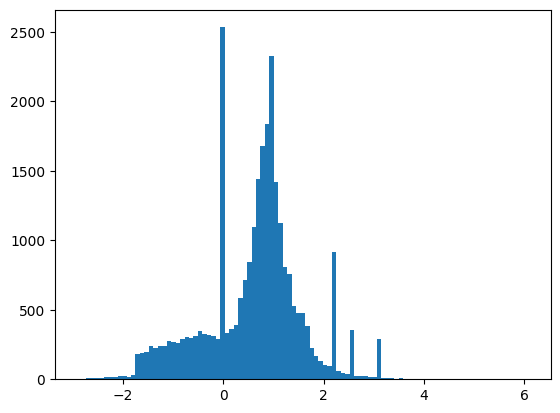

In [12]:
for features,label in packed_ds.batch(1000).take(1):
  print(features[0])
  plt.hist(features.numpy().flatten(), bins = 101)

To keep this tutorial relatively short, use just the first 1,000 samples for validation, and the next 10,000 for training:

In [13]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

The `Dataset.skip` and `Dataset.take` methods make this easy.

At the same time, use the `Dataset.cache` method to ensure that the loader doesn't need to re-read the data from the file on each epoch:

In [14]:
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

In [15]:
train_ds

<CacheDataset element_spec=(TensorSpec(shape=(28,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

These datasets return individual examples. Use the `Dataset.batch` method to create batches of an appropriate size for training. Before batching, also remember to use `Dataset.shuffle` and `Dataset.repeat` on the training set.

In [16]:
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

## Demonstrate overfitting

The simplest way to prevent overfitting is to start with a small model: A model with a small number of learnable parameters (which is determined by the number of layers and the number of units per layer). In deep learning, the number of learnable parameters in a model is often referred to as the model's "capacity".

Intuitively, a model with more parameters will have more "memorization capacity" and therefore will be able to easily learn a perfect dictionary-like mapping between training samples and their targets, a mapping without any generalization power, but this would be useless when making predictions on previously unseen data.

Always keep this in mind: deep learning models tend to be good at fitting to the training data, but the real challenge is generalization, not fitting.

On the other hand, if the network has limited memorization resources, it will not be able to learn the mapping as easily. To minimize its loss, it will have to learn compressed representations that have more predictive power. At the same time, if you make your model too small, it will have difficulty fitting to the training data. There is a balance between "too much capacity" and "not enough capacity".

Unfortunately, there is no magical formula to determine the right size or architecture of your model (in terms of the number of layers, or the right size for each layer). You will have to experiment using a series of different architectures.

To find an appropriate model size, it's best to start with relatively few layers and parameters, then begin increasing the size of the layers or adding new layers until you see diminishing returns on the validation loss.

Start with a simple model using only densely-connected layers (`tf.keras.layers.Dense`) as a baseline, then create larger models, and compare them.

### Training procedure

Many models train better if you gradually reduce the learning rate during training. Use `tf.keras.optimizers.schedules` to reduce the learning rate over time:

In [17]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

The code above sets a `tf.keras.optimizers.schedules.InverseTimeDecay` to hyperbolically decrease the learning rate to 1/2 of the base rate at 1,000 epochs, 1/3 at 2,000 epochs, and so on.

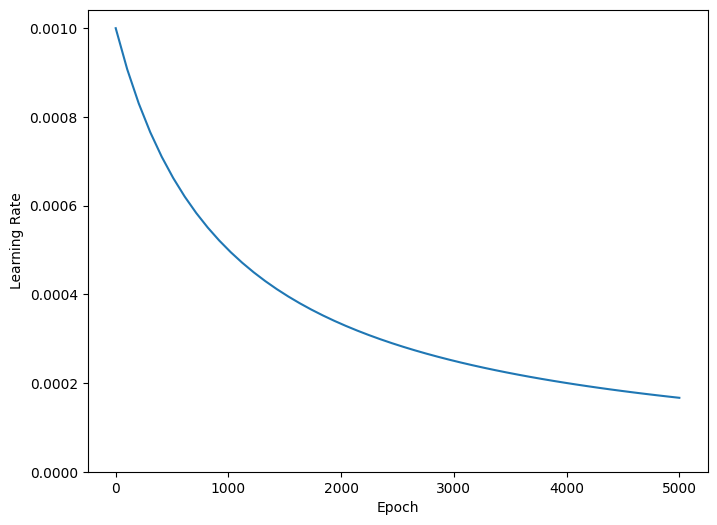

In [18]:
step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')


Each model in this tutorial will use the same training configuration. So set these up in a reusable way, starting with the list of callbacks.

The training for this tutorial runs for many short epochs. To reduce the logging noise use the `tfdocs.EpochDots` which simply prints a `.` for each epoch, and a full set of metrics every 100 epochs.

Next include `tf.keras.callbacks.EarlyStopping` to avoid long and unnecessary training times. Note that this callback is set to monitor the `val_binary_crossentropy`, not the `val_loss`. This difference will be important later.

Use `callbacks.TensorBoard` to generate TensorBoard logs for the training.


In [19]:
def get_callbacks(name):
  return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
    tf.keras.callbacks.TensorBoard(logdir/name),
  ]

Similarly each model will use the same `Model.compile` and `Model.fit` settings:

In [20]:
def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
  if optimizer is None:
    optimizer = get_optimizer()
  model.compile(optimizer=optimizer,
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[
                  tf.keras.metrics.BinaryCrossentropy(
                      from_logits=True, name='binary_crossentropy'),
                  'accuracy'])

  model.summary()

  history = model.fit(
    train_ds,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs=max_epochs,
    validation_data=validate_ds,
    callbacks=get_callbacks(name),
    verbose=0)
  return history

### Tiny model

Start by training a model:

In [21]:
tiny_model = tf.keras.Sequential([
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(1)
])

In [22]:
size_histories = {}

In [23]:
size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny')

Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 dense (Dense)               (None, 16)                464       


 dense_1 (Dense)             (None, 1)                 17        


Total params: 481


Trainable params: 481


Non-trainable params: 0


_________________________________________________________________



Epoch: 0, accuracy:0.4948,  binary_crossentropy:0.8694,  loss:0.8694,  val_accuracy:0.4780,  val_binary_crossentropy:0.8066,  val_loss:0.8066,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 100, accuracy:0.5970,  binary_crossentropy:0.6282,  loss:0.6282,  val_accuracy:0.5810,  val_binary_crossentropy:0.6287,  val_loss:0.6287,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 200, accuracy:0.6231,  binary_crossentropy:0.6143,  loss:0.6143,  val_accuracy:0.5910,  val_binary_crossentropy:0.6164,  val_loss:0.6164,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 300, accuracy:0.6396,  binary_crossentropy:0.6032,  loss:0.6032,  val_accuracy:0.6170,  val_binary_crossentropy:0.6024,  val_loss:0.6024,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 400, accuracy:0.6538,  binary_crossentropy:0.5951,  loss:0.5951,  val_accuracy:0.6580,  val_binary_crossentropy:0.5929,  val_loss:0.5929,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 500, accuracy:0.6606,  binary_crossentropy:0.5902,  loss:0.5902,  val_accuracy:0.6510,  val_binary_crossentropy:0.5897,  val_loss:0.5897,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 600, accuracy:0.6635,  binary_crossentropy:0.5864,  loss:0.5864,  val_accuracy:0.6590,  val_binary_crossentropy:0.5873,  val_loss:0.5873,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 700, accuracy:0.6699,  binary_crossentropy:0.5839,  loss:0.5839,  val_accuracy:0.6680,  val_binary_crossentropy:0.5846,  val_loss:0.5846,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 800, accuracy:0.6709,  binary_crossentropy:0.5810,  loss:0.5810,  val_accuracy:0.6580,  val_binary_crossentropy:0.5847,  val_loss:0.5847,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 900, accuracy:0.6724,  binary_crossentropy:0.5792,  loss:0.5792,  val_accuracy:0.6690,  val_binary_crossentropy:0.5838,  val_loss:0.5838,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 1000, accuracy:0.6771,  binary_crossentropy:0.5776,  loss:0.5776,  val_accuracy:0.6690,  val_binary_crossentropy:0.5847,  val_loss:0.5847,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 1100, accuracy:0.6809,  binary_crossentropy:0.5760,  loss:0.5760,  val_accuracy:0.6730,  val_binary_crossentropy:0.5842,  val_loss:0.5842,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 1200, accuracy:0.6770,  binary_crossentropy:0.5748,  loss:0.5748,  val_accuracy:0.6870,  val_binary_crossentropy:0.5834,  val_loss:0.5834,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

Now check how the model did:

(0.5, 0.7)

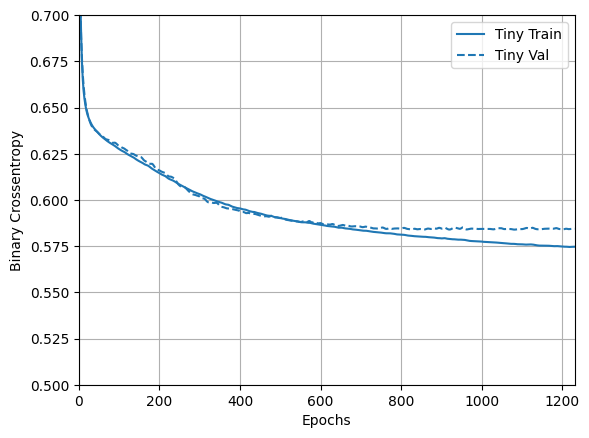

In [24]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])

### Small model

To check if you can beat the performance of the small model, progressively train some larger models.

Try two hidden layers with 16 units each:

In [25]:
small_model = tf.keras.Sequential([
    # `input_shape` is only required here so that `.summary` works.
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(16, activation='elu'),
    layers.Dense(1)
])

In [26]:
size_histories['Small'] = compile_and_fit(small_model, 'sizes/Small')

Model: "sequential_1"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 dense_2 (Dense)             (None, 16)                464       


 dense_3 (Dense)             (None, 16)                272       


 dense_4 (Dense)             (None, 1)                 17        


Total params: 753


Trainable params: 753


Non-trainable params: 0


_________________________________________________________________



Epoch: 0, accuracy:0.4831,  binary_crossentropy:0.7204,  loss:0.7204,  val_accuracy:0.4610,  val_binary_crossentropy:0.7135,  val_loss:0.7135,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 100, accuracy:0.6112,  binary_crossentropy:0.6185,  loss:0.6185,  val_accuracy:0.5890,  val_binary_crossentropy:0.6311,  val_loss:0.6311,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 200, accuracy:0.6451,  binary_crossentropy:0.5981,  loss:0.5981,  val_accuracy:0.6080,  val_binary_crossentropy:0.6171,  val_loss:0.6171,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 300, accuracy:0.6702,  binary_crossentropy:0.5804,  loss:0.5804,  val_accuracy:0.6300,  val_binary_crossentropy:0.5993,  val_loss:0.5993,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 400, accuracy:0.6835,  binary_crossentropy:0.5711,  loss:0.5711,  val_accuracy:0.6390,  val_binary_crossentropy:0.5942,  val_loss:0.5942,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 500, accuracy:0.6873,  binary_crossentropy:0.5657,  loss:0.5657,  val_accuracy:0.6690,  val_binary_crossentropy:0.5907,  val_loss:0.5907,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 600, accuracy:0.6948,  binary_crossentropy:0.5613,  loss:0.5613,  val_accuracy:0.6630,  val_binary_crossentropy:0.5913,  val_loss:0.5913,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 700, accuracy:0.6953,  binary_crossentropy:0.5586,  loss:0.5586,  val_accuracy:0.6610,  val_binary_crossentropy:0.5910,  val_loss:0.5910,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

### Medium model

Now try three hidden layers with 64 units each:

In [27]:
medium_model = tf.keras.Sequential([
    layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(64, activation='elu'),
    layers.Dense(64, activation='elu'),
    layers.Dense(1)
])

And train the model using the same data:

In [28]:
size_histories['Medium']  = compile_and_fit(medium_model, "sizes/Medium")

Model: "sequential_2"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 dense_5 (Dense)             (None, 64)                1856      


 dense_6 (Dense)             (None, 64)                4160      


 dense_7 (Dense)             (None, 64)                4160      


 dense_8 (Dense)             (None, 1)                 65        


Total params: 10,241


Trainable params: 10,241


Non-trainable params: 0


_________________________________________________________________



Epoch: 0, accuracy:0.4985,  binary_crossentropy:0.6851,  loss:0.6851,  val_accuracy:0.5080,  val_binary_crossentropy:0.6732,  val_loss:0.6732,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 100, accuracy:0.7111,  binary_crossentropy:0.5318,  loss:0.5318,  val_accuracy:0.6560,  val_binary_crossentropy:0.6000,  val_loss:0.6000,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 200, accuracy:0.7788,  binary_crossentropy:0.4423,  loss:0.4423,  val_accuracy:0.6520,  val_binary_crossentropy:0.6531,  val_loss:0.6531,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

### Large model

As an exercise, you can create an even larger model and check how quickly it begins overfitting. Next, add to this benchmark a network that has much more capacity, far more than the problem would warrant:

In [29]:
large_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(1)
])

And, again, train the model using the same data:

In [30]:
size_histories['large'] = compile_and_fit(large_model, "sizes/large")

Model: "sequential_3"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 dense_9 (Dense)             (None, 512)               14848     


 dense_10 (Dense)            (None, 512)               262656    


 dense_11 (Dense)            (None, 512)               262656    


 dense_12 (Dense)            (None, 512)               262656    


 dense_13 (Dense)            (None, 1)                 513       


Total params: 803,329


Trainable params: 803,329


Non-trainable params: 0


_________________________________________________________________



Epoch: 0, accuracy:0.4974,  binary_crossentropy:0.8278,  loss:0.8278,  val_accuracy:0.5370,  val_binary_crossentropy:0.7014,  val_loss:0.7014,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 100, accuracy:1.0000,  binary_crossentropy:0.0026,  loss:0.0026,  val_accuracy:0.6530,  val_binary_crossentropy:1.7044,  val_loss:1.7044,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 200, accuracy:1.0000,  binary_crossentropy:0.0002,  loss:0.0002,  val_accuracy:0.6550,  val_binary_crossentropy:2.3394,  val_loss:2.3394,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

### Plot the training and validation losses

The solid lines show the training loss, and the dashed lines show the validation loss (remember: a lower validation loss indicates a better model).

While building a larger model gives it more power, if this power is not constrained somehow it can easily overfit to the training set.

In this example, typically, only the `"Tiny"` model manages to avoid overfitting altogether, and each of the larger models overfit the data more quickly. This becomes so severe for the `"large"` model that you need to switch the plot to a log-scale to really figure out what's happening.

This is apparent if you plot and compare the validation metrics to the training metrics.

* It's normal for there to be a small difference.
* If both metrics are moving in the same direction, everything is fine.
* If the validation metric begins to stagnate while the training metric continues to improve, you are probably close to overfitting.
* If the validation metric is going in the wrong direction, the model is clearly overfitting.

Text(0.5, 0, 'Epochs [Log Scale]')

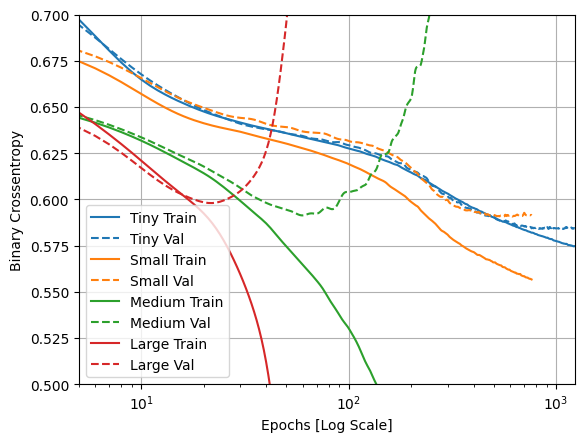

In [31]:
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 0.7])
plt.xlabel("Epochs [Log Scale]")

Note: All the above training runs used the `callbacks.EarlyStopping` to end the training once it was clear the model was not making progress.

### View in TensorBoard

These models all wrote TensorBoard logs during training.

Open an embedded  TensorBoard viewer inside a notebook:

In [ ]:
#docs_infra: no_execute

# Load the TensorBoard notebook extension
%load_ext tensorboard

# Open an embedded TensorBoard viewer
%tensorboard --logdir {logdir}/sizes

You can view the [results of a previous run](https://tensorboard.dev/experiment/vW7jmmF9TmKmy3rbheMQpw/#scalars&_smoothingWeight=0.97) of this notebook on [TensorBoard.dev](https://tensorboard.dev/).

TensorBoard.dev is a managed experience for hosting, tracking, and sharing ML experiments with everyone.

It's also included in an `<iframe>` for convenience:

In [32]:
display.IFrame(
    src="https://tensorboard.dev/experiment/vW7jmmF9TmKmy3rbheMQpw/#scalars&_smoothingWeight=0.97",
    width="100%", height="800px")

If you want to share TensorBoard results you can upload the logs to [TensorBoard.dev](https://tensorboard.dev/) by copying the following into a code-cell.

Note: This step requires a Google account.

```
!tensorboard dev upload --logdir  {logdir}/sizes
```

Caution: This command does not terminate. It's designed to continuously upload the results of long-running experiments. Once your data is uploaded you need to stop it using the "interrupt execution" option in your notebook tool.

## Strategies to prevent overfitting

Before getting into the content of this section copy the training logs from the `"Tiny"` model above, to use as a baseline for comparison.

In [33]:
shutil.rmtree(logdir/'regularizers/Tiny', ignore_errors=True)
shutil.copytree(logdir/'sizes/Tiny', logdir/'regularizers/Tiny')

PosixPath('/tmpfs/tmp/tmpp1hfcxvw/tensorboard_logs/regularizers/Tiny')

In [34]:
regularizer_histories = {}
regularizer_histories['Tiny'] = size_histories['Tiny']

### Add weight regularization


You may be familiar with Occam's Razor principle: given two explanations for something, the explanation most likely to be correct is the "simplest" one, the one that makes the least amount of assumptions. This also applies to the models learned by neural networks: given some training data and a network architecture, there are multiple sets of weights values (multiple models) that could explain the data, and simpler models are less likely to overfit than complex ones.

A "simple model" in this context is a model where the distribution of parameter values has less entropy (or a model with fewer parameters altogether, as demonstrated in the section above). Thus a common way to mitigate overfitting is to put constraints on the complexity of a network by forcing its weights only to take small values, which makes the distribution of weight values more "regular". This is called "weight regularization", and it is done by adding to the loss function of the network a cost associated with having large weights. This cost comes in two flavors:

* [L1 regularization](https://developers.google.com/machine-learning/glossary/#L1_regularization), where the cost added is proportional to the absolute value of the weights coefficients (i.e. to what is called the "L1 norm" of the weights).

* [L2 regularization](https://developers.google.com/machine-learning/glossary/#L2_regularization), where the cost added is proportional to the square of the value of the weights coefficients (i.e. to what is called the squared "L2 norm" of the weights). L2 regularization is also called weight decay in the context of neural networks. Don't let the different name confuse you: weight decay is mathematically the exact same as L2 regularization.

L1 regularization pushes weights towards exactly zero, encouraging a sparse model. L2 regularization will penalize the weights parameters without making them sparse since the penalty goes to zero for small weights—one reason why L2 is more common.

In `tf.keras`, weight regularization is added by passing weight regularizer instances to layers as keyword arguments. Add L2 weight regularization:

In [35]:
l2_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001),
                 input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1)
])

regularizer_histories['l2'] = compile_and_fit(l2_model, "regularizers/l2")

Model: "sequential_4"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 dense_14 (Dense)            (None, 512)               14848     


 dense_15 (Dense)            (None, 512)               262656    


 dense_16 (Dense)            (None, 512)               262656    


 dense_17 (Dense)            (None, 512)               262656    


 dense_18 (Dense)            (None, 1)                 513       


Total params: 803,329


Trainable params: 803,329


Non-trainable params: 0


_________________________________________________________________



Epoch: 0, accuracy:0.5120,  binary_crossentropy:0.8283,  loss:2.3483,  val_accuracy:0.4670,  val_binary_crossentropy:0.6852,  val_loss:2.1292,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 100, accuracy:0.6603,  binary_crossentropy:0.5968,  loss:0.6192,  val_accuracy:0.6150,  val_binary_crossentropy:0.5912,  val_loss:0.6137,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 200, accuracy:0.6700,  binary_crossentropy:0.5849,  loss:0.6081,  val_accuracy:0.6880,  val_binary_crossentropy:0.5732,  val_loss:0.5962,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 300, accuracy:0.6792,  binary_crossentropy:0.5739,  loss:0.5975,  val_accuracy:0.6500,  val_binary_crossentropy:0.5763,  val_loss:0.5999,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 400, accuracy:0.6831,  binary_crossentropy:0.5750,  loss:0.6251,  val_accuracy:0.6800,  val_binary_crossentropy:0.5720,  val_loss:0.6215,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

`l2(0.001)` means that every coefficient in the weight matrix of the layer will add `0.001 * weight_coefficient_value**2` to the total **loss** of the network.

That is why we're monitoring the `binary_crossentropy` directly. Because it doesn't have this regularization component mixed in.

So, that same `"Large"` model with an `L2` regularization penalty performs much better:


(0.5, 0.7)

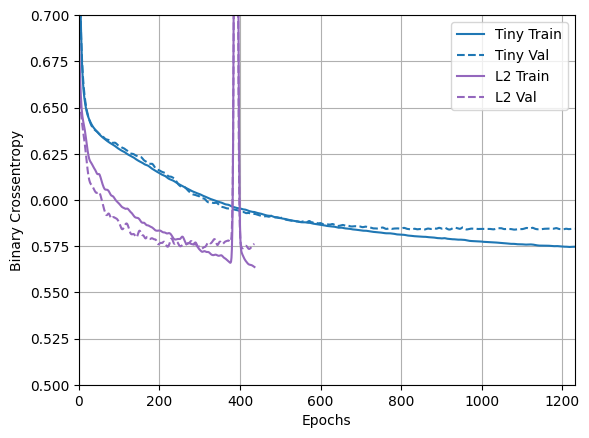

In [36]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

As demonstrated in the diagram above, the `"L2"` regularized model is now much more competitive with the `"Tiny"` model. This `"L2"` model is also much more resistant to overfitting than the `"Large"` model it was based on despite having the same number of parameters.

#### More info

There are two important things to note about this sort of regularization:

1. If you are writing your own training loop, then you need to be sure to ask the model for its regularization losses.

In [37]:
result = l2_model(features)
regularization_loss=tf.add_n(l2_model.losses)

2. This implementation works by adding the weight penalties to the model's loss, and then applying a standard optimization procedure after that.

There is a second approach that instead only runs the optimizer on the raw loss, and then while applying the calculated step the optimizer also applies some weight decay. This "decoupled weight decay" is used in optimizers like `tf.keras.optimizers.Ftrl` and `tfa.optimizers.AdamW`.

### Add dropout

Dropout is one of the most effective and most commonly used regularization techniques for neural networks, developed by Hinton and his students at the University of Toronto.

The intuitive explanation for dropout is that because individual nodes in the network cannot rely on the output of the others, each node must output features that are useful on their own.

Dropout, applied to a layer, consists of randomly "dropping out" (i.e. set to zero) a number of output features of the layer during training. For example, a given layer would normally have returned a vector `[0.2, 0.5, 1.3, 0.8, 1.1]` for a given input sample during training; after applying dropout, this vector will have a few zero entries distributed at random, e.g. `[0, 0.5, 1.3, 0, 1.1]`.

The "dropout rate" is the fraction of the features that are being zeroed-out; it is usually set between 0.2 and 0.5. At test time, no units are dropped out, and instead the layer's output values are scaled down by a factor equal to the dropout rate, so as to balance for the fact that more units are active than at training time.

In Keras, you can introduce dropout in a network via the `tf.keras.layers.Dropout` layer, which gets applied to the output of layer right before.

Add two dropout layers to your network to check how well they do at reducing overfitting:

In [38]:
dropout_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['dropout'] = compile_and_fit(dropout_model, "regularizers/dropout")

Model: "sequential_5"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 dense_19 (Dense)            (None, 512)               14848     


 dropout (Dropout)           (None, 512)               0         


 dense_20 (Dense)            (None, 512)               262656    


 dropout_1 (Dropout)         (None, 512)               0         


 dense_21 (Dense)            (None, 512)               262656    


 dropout_2 (Dropout)         (None, 512)               0         


 dense_22 (Dense)            (None, 512)               262656    


 dropout_3 (Dropout)         (None, 512)               0         


 dense_23 (Dense)            (None, 1)                 513       


Total params: 803,329


Trainable params: 803,329


Non-trainable params: 0


_________________________________________________________________



Epoch: 0, accuracy:0.5092,  binary_crossentropy:0.8112,  loss:0.8112,  val_accuracy:0.4970,  val_binary_crossentropy:0.6830,  val_loss:0.6830,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 100, accuracy:0.6586,  binary_crossentropy:0.5944,  loss:0.5944,  val_accuracy:0.6970,  val_binary_crossentropy:0.5760,  val_loss:0.5760,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 200, accuracy:0.6921,  binary_crossentropy:0.5558,  loss:0.5558,  val_accuracy:0.6840,  val_binary_crossentropy:0.5790,  val_loss:0.5790,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 300, accuracy:0.7222,  binary_crossentropy:0.5124,  loss:0.5124,  val_accuracy:0.6740,  val_binary_crossentropy:0.6136,  val_loss:0.6136,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

(0.5, 0.7)

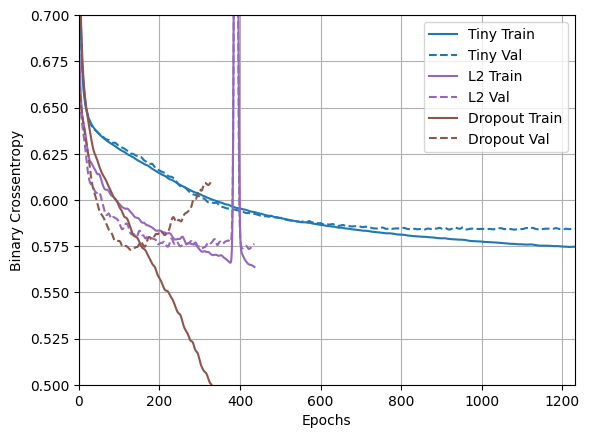

In [39]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

It's clear from this plot that both of these regularization approaches improve the behavior of the `"Large"` model. But this still doesn't beat even the `"Tiny"` baseline.

Next try them both, together, and see if that does better.

### Combined L2 + dropout

In [40]:
combined_model = tf.keras.Sequential([
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['combined'] = compile_and_fit(combined_model, "regularizers/combined")

Model: "sequential_6"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 dense_24 (Dense)            (None, 512)               14848     


 dropout_4 (Dropout)         (None, 512)               0         


 dense_25 (Dense)            (None, 512)               262656    


 dropout_5 (Dropout)         (None, 512)               0         


 dense_26 (Dense)            (None, 512)               262656    


 dropout_6 (Dropout)         (None, 512)               0         


 dense_27 (Dense)            (None, 512)               262656    


 dropout_7 (Dropout)         (None, 512)               0         


 dense_28 (Dense)            (None, 1)                 513       


Total params: 803,329


Trainable params: 803,329


Non-trainable params: 0


_________________________________________________________________



Epoch: 0, accuracy:0.5094,  binary_crossentropy:0.7898,  loss:0.9481,  val_accuracy:0.4780,  val_binary_crossentropy:0.6806,  val_loss:0.8381,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 100, accuracy:0.6362,  binary_crossentropy:0.6082,  loss:0.6368,  val_accuracy:0.6430,  val_binary_crossentropy:0.5899,  val_loss:0.6183,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 200, accuracy:0.6661,  binary_crossentropy:0.5915,  loss:0.6159,  val_accuracy:0.6670,  val_binary_crossentropy:0.5764,  val_loss:0.6007,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 300, accuracy:0.6674,  binary_crossentropy:0.5855,  loss:0.6133,  val_accuracy:0.6840,  val_binary_crossentropy:0.5669,  val_loss:0.5946,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 400, accuracy:0.6706,  binary_crossentropy:0.5814,  loss:0.6104,  val_accuracy:0.6940,  val_binary_crossentropy:0.5627,  val_loss:0.5918,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 500, accuracy:0.6856,  binary_crossentropy:0.5669,  loss:0.5979,  val_accuracy:0.6910,  val_binary_crossentropy:0.5550,  val_loss:0.5860,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 600, accuracy:0.6750,  binary_crossentropy:0.5741,  loss:0.6065,  val_accuracy:0.6790,  val_binary_crossentropy:0.5596,  val_loss:0.5920,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 700, accuracy:0.6867,  binary_crossentropy:0.5610,  loss:0.5953,  val_accuracy:0.6890,  val_binary_crossentropy:0.5521,  val_loss:0.5863,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 800, accuracy:0.6946,  binary_crossentropy:0.5557,  loss:0.5913,  val_accuracy:0.6780,  val_binary_crossentropy:0.5502,  val_loss:0.5858,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 900, accuracy:0.6939,  binary_crossentropy:0.5551,  loss:0.5922,  val_accuracy:0.7030,  val_binary_crossentropy:0.5401,  val_loss:0.5772,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 1000, accuracy:0.6982,  binary_crossentropy:0.5496,  loss:0.5883,  val_accuracy:0.6980,  val_binary_crossentropy:0.5419,  val_loss:0.5806,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

(0.5, 0.7)

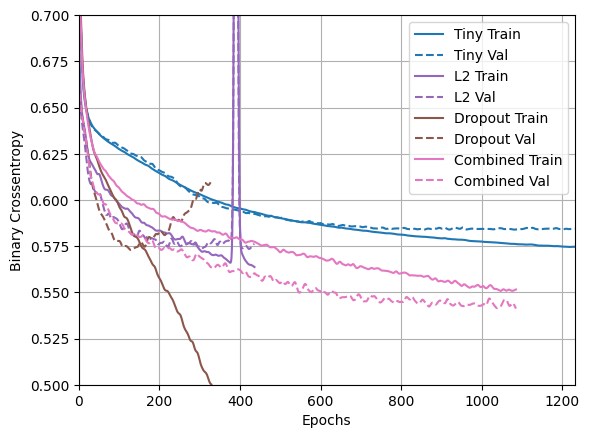

In [41]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

This model with the `"Combined"` regularization is obviously the best one so far.

### View in TensorBoard

These models also recorded TensorBoard logs.

To open an embedded  tensorboard viewer inside a notebook, copy the following into a code-cell:

```
%tensorboard --logdir {logdir}/regularizers
```

You can view the [results of a previous run](https://tensorboard.dev/experiment/fGInKDo8TXes1z7HQku9mw/#scalars&_smoothingWeight=0.97) of this notebook on [TensorBoard.dev](https://tensorboard.dev/).

It's also included in an `<iframe>` for convenience:

In [42]:
display.IFrame(
    src="https://tensorboard.dev/experiment/fGInKDo8TXes1z7HQku9mw/#scalars&_smoothingWeight=0.97",
    width = "100%",
    height="800px")


This was uploaded with:

```
!tensorboard dev upload --logdir  {logdir}/regularizers
```

## Conclusions

To recap, here are the most common ways to prevent overfitting in neural networks:

* Get more training data.
* Reduce the capacity of the network.
* Add weight regularization.
* Add dropout.

Two important approaches not covered in this guide are:

* [Data augmentation](../images/data_augmentation.ipynb)
* Batch normalization (`tf.keras.layers.BatchNormalization`)

Remember that each method can help on its own, but often combining them can be even more effective.